## Characterize obstacle inputs 
Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

%matplotlib inline
%config InlineBackend.figure_format='retina'

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,Site Type,Site Notes,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy
0,t007,A2719,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),NaN,Rural,No lidar data. This turbine is absolutely surr...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,50.0,Proprietary
1,t024,A2672,Washoe,Thomas Danzinger,NV,39.331088,-119.820230,30,QL1,2020.0,Rural/Suburban,Straight forward high desert site outside Reno...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN
2,t028,A3479,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,Suburban,Impressive amount of vegetation – some section...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN
3,t034,A2715,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,QL2,2018.0,Rural,"Lakeshore, heavily forested.",Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego.qc.csv,43.464,-76.511,15.0,Public
4,t041,A2272,Rockford,Fossil Park,IA,43.047418,-92.981674,37,QL2,2020.0,Rural,"Very simple site, one building and a couple sm...",Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN


### Select which sites need to be processed and wind data source

In [3]:
# Small test with several sites
#selected = ["t133", "t135"]

# Process all sites:
selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
selected = [x for x in selected if not(x in ["t007", "t074"])]
print(selected)

wind_sources = ["wtk", "wtk_led_2019"] # One of: ["wtk", "wtk_led_2018", "wtk_led_2019"]

['t024', 't028', 't034', 't041', 't083', 't114', 't133', 't135', 't139', 't140', 't169', 't170', 't182', 't183', 't192', 't207', 't221']


### Develop, test, and demonstrate `filter_obstacles()`

In [5]:
for tid in selected:
    if tid == "t135":
        continue
    
    index_row = index[index["APRS ID"] == tid].iloc[0]
    z_turbine = index_row["Hub Height (m)"]
    
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    print("Processing: ", obstacle_data_file)
    
    if os.path.exists(obstacle_data_file):
        print("BEFORE filtering (%s):" % obstacle_data_file)
        display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        
        print("AFTER filtering (%s):" % obstacle_data_file)
        display(obstacle_df)
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)
    #break

Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t024v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t024v2.json):


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-54594267,201808.0,3.0,ai,None,-0.108398,10.475586,5.755239,1391,6.360962,"POLYGON ((-119.82480 39.33605, -119.82500 39.3..."
1,US-98686935,201808.0,3.0,ai,None,-0.044556,8.814819,4.752457,834,4.615967,"POLYGON ((-119.82413 39.32681, -119.82422 39.3..."
2,US-33229886,201808.0,3.0,ai,None,-0.048096,4.495239,3.025936,104,3.846680,"POLYGON ((-119.81708 39.32649, -119.81715 39.3..."
3,US-33229879,201808.0,3.0,ai,None,-1603.198486,8.679810,-73.526401,321,7.563354,"POLYGON ((-119.81710 39.32658, -119.81697 39.3..."
4,US-37045571,201808.0,3.0,ai,None,-0.035522,7.524780,5.092442,586,5.599060,"POLYGON ((-119.82232 39.32961, -119.82245 39.3..."
...,...,...,...,...,...,...,...,...,...,...,...
91,None,NaN,NaN,None,tree,-0.113159,11.475830,1.333868,162,0.203186,"POLYGON ((-119.82098 39.33158, -119.82101 39.3..."
92,None,NaN,NaN,None,tree,-0.079102,6.375244,1.494344,36,0.238708,"POLYGON ((-119.82090 39.33064, -119.82092 39.3..."
93,None,NaN,NaN,None,tree,0.110107,3.312744,1.595688,16,1.688965,"POLYGON ((-119.81928 39.33100, -119.81930 39.3..."
94,None,NaN,NaN,None,tree,-0.021851,15.315430,7.393769,85,7.389282,"POLYGON ((-119.81914 39.33076, -119.81916 39.3..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t024v2.json):


,height,geometry,feature_type
0,6.360962,"POLYGON ((-119.82480 39.33605, -119.82500 39.3...",building
1,4.615967,"POLYGON ((-119.82413 39.32681, -119.82422 39.3...",building
2,3.846680,"POLYGON ((-119.81708 39.32649, -119.81715 39.3...",building
3,7.563354,"POLYGON ((-119.81710 39.32658, -119.81697 39.3...",building
4,5.599060,"POLYGON ((-119.82232 39.32961, -119.82245 39.3...",building
...,...,...,...
89,11.475830,"POLYGON ((-119.82098 39.33158, -119.82101 39.3...",tree
90,6.375244,"POLYGON ((-119.82090 39.33064, -119.82092 39.3...",tree
91,3.312744,"POLYGON ((-119.81928 39.33100, -119.81930 39.3...",tree
92,15.315430,"POLYGON ((-119.81914 39.33076, -119.81916 39.3...",tree


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t028v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t028v2.json):


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-82689554,None,3.0,ai,None,-0.004456,6.632874,4.189349,255,4.292328,"POLYGON ((-75.59833 40.84681, -75.59826 40.846..."
1,US-82689572,None,3.0,ai,None,0.063904,18.875336,4.245595,159,4.229828,"POLYGON ((-75.59748 40.84717, -75.59757 40.847..."
2,US-82689584,None,3.0,ai,None,-0.002594,5.883820,4.144785,208,4.868408,"POLYGON ((-75.59663 40.84725, -75.59663 40.847..."
3,US-82689492,None,3.0,ai,None,-0.080505,6.561523,4.297417,160,4.592773,"POLYGON ((-75.59960 40.84741, -75.59968 40.847..."
4,US-82689444,None,3.0,ai,None,0.302063,4.208252,2.738628,100,2.664902,"POLYGON ((-75.59690 40.84741, -75.59680 40.847..."
...,...,...,...,...,...,...,...,...,...,...,...
177,None,None,NaN,None,tree,-0.004669,10.301422,4.219390,186,4.590988,"POLYGON ((-75.59813 40.85044, -75.59820 40.850..."
178,None,None,NaN,None,tree,-0.004883,15.565460,5.433000,669,5.017029,"POLYGON ((-75.59817 40.85029, -75.59813 40.850..."
179,None,None,NaN,None,tree,-0.004578,7.914093,1.520275,152,0.004745,"POLYGON ((-75.59855 40.85057, -75.59858 40.850..."
180,None,None,NaN,None,tree,-0.004791,6.365265,1.550058,163,0.004883,"POLYGON ((-75.59865 40.85060, -75.59870 40.850..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t028v2.json):


,height,geometry,feature_type
0,4.292328,"POLYGON ((-75.59833 40.84681, -75.59826 40.846...",building
1,4.229828,"POLYGON ((-75.59748 40.84717, -75.59757 40.847...",building
2,4.868408,"POLYGON ((-75.59663 40.84725, -75.59663 40.847...",building
3,4.592773,"POLYGON ((-75.59960 40.84741, -75.59968 40.847...",building
4,2.664902,"POLYGON ((-75.59690 40.84741, -75.59680 40.847...",building
...,...,...,...
169,10.301422,"POLYGON ((-75.59813 40.85044, -75.59820 40.850...",tree
170,15.565460,"POLYGON ((-75.59817 40.85029, -75.59813 40.850...",tree
171,7.914093,"POLYGON ((-75.59855 40.85057, -75.59858 40.850...",tree
172,6.365265,"POLYGON ((-75.59865 40.85060, -75.59870 40.850...",tree


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t034v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t034v2.json):


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w833073342,202008.0,3.0,ai,None,-0.000008,46.360992,4.512737,139,4.408997,"POLYGON ((-76.37136 43.52345, -76.37119 43.523..."
1,osm-w833073470,202008.0,3.0,ai,None,0.583992,3.392998,2.703036,50,2.815498,"POLYGON ((-76.37617 43.52384, -76.37617 43.523..."
2,osm-w833073430,202106.0,3.0,ai,None,-0.000008,4.040993,2.922440,117,3.115997,"POLYGON ((-76.37580 43.52424, -76.37594 43.524..."
3,osm-w833073514,202106.0,3.0,ai,None,0.000000,7.299995,5.179061,47,5.959000,"POLYGON ((-76.37066 43.52505, -76.37065 43.524..."
4,osm-w833073971,202106.0,3.0,ai,None,-0.048004,7.764992,5.048864,196,5.281494,"POLYGON ((-76.37094 43.52061, -76.37106 43.520..."
5,osm-w833074170,202106.0,3.0,ai,None,-0.000008,6.613998,4.776191,164,4.994995,"POLYGON ((-76.37499 43.52466, -76.37521 43.524..."
6,osm-w833074959,202008.0,3.0,ai,None,-0.000008,9.150993,2.964585,68,3.073997,"POLYGON ((-76.37203 43.52339, -76.37213 43.523..."
7,osm-w833075119,202106.0,3.0,ai,None,-79.244003,5.183998,-26.127932,99,3.646996,"POLYGON ((-76.37837 43.52360, -76.37827 43.523..."
8,osm-w833075290,202106.0,3.0,ai,None,-0.091003,7.850998,5.847451,88,6.515999,"POLYGON ((-76.37170 43.52309, -76.37179 43.523..."
9,osm-w833075699,202106.0,3.0,ai,None,0.348999,5.210991,3.846252,160,4.153496,"POLYGON ((-76.37824 43.52419, -76.37802 43.524..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t034v2.json):


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:313: UserWarning: Detected at least 1 obstacle that is as tall as the studied turbine:
      id  date     height heightSrc feature_type  height_min  height_max  \
40  None   NaN  41.015999      None         tree   -0.026001   41.015999   
48  None   NaN  39.621994      None         tree   -0.003006   39.621994   

    height_mean  height_count  height_median  \
40     3.945196          1849       2.626999   
48     6.718453          1803       5.336998   

                                             geometry  
40  POLYGON ((-76.37180 43.52360, -76.37171 43.523...  
48  POLYGON ((-76.37276 43.52496, -76.37280 43.524...  
  warnings.warn("Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \


,height,geometry,feature_type
0,4.408997,"POLYGON ((-76.37136 43.52345, -76.37119 43.523...",building
1,2.815498,"POLYGON ((-76.37617 43.52384, -76.37617 43.523...",building
2,3.115997,"POLYGON ((-76.37580 43.52424, -76.37594 43.524...",building
3,5.959000,"POLYGON ((-76.37066 43.52505, -76.37065 43.524...",building
4,5.281494,"POLYGON ((-76.37094 43.52061, -76.37106 43.520...",building
5,4.994995,"POLYGON ((-76.37499 43.52466, -76.37521 43.524...",building
6,3.073997,"POLYGON ((-76.37203 43.52339, -76.37213 43.523...",building
7,3.646996,"POLYGON ((-76.37837 43.52360, -76.37827 43.523...",building
8,6.515999,"POLYGON ((-76.37170 43.52309, -76.37179 43.523...",building
9,4.153496,"POLYGON ((-76.37824 43.52419, -76.37802 43.524...",building


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t041v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t041v2.json):


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-122827180,None,3.0,ai,None,0.000000,8.710022,6.395153,357,6.829987,"POLYGON ((-92.98735 43.04390, -92.98712 43.043..."
1,US-122827169,None,3.0,ai,None,-0.010010,7.220001,4.570844,308,4.884995,"POLYGON ((-92.98631 43.04416, -92.98631 43.043..."
2,US-122827267,None,3.0,ai,None,0.000000,0.800018,0.084722,216,0.000000,"POLYGON ((-92.98707 43.04416, -92.98707 43.044..."
3,US-122827175,None,3.0,ai,None,0.000000,11.599976,5.838103,448,4.754990,"POLYGON ((-92.98664 43.04439, -92.98694 43.044..."
4,US-122827289,None,3.0,ai,None,-0.010010,7.509979,4.190520,192,4.519989,"POLYGON ((-92.98710 43.04430, -92.98710 43.044..."
5,US-122827335,None,3.0,ai,None,0.000000,6.329987,4.236273,483,4.779999,"POLYGON ((-92.97579 43.04433, -92.97579 43.044..."
6,US-122827210,None,3.0,ai,None,-0.029999,2.300018,0.311875,64,0.004990,"POLYGON ((-92.98634 43.04448, -92.98634 43.044..."
7,US-122827298,None,3.0,ai,None,0.000000,9.360016,6.087379,187,6.919983,"POLYGON ((-92.98685 43.04463, -92.98685 43.044..."
8,US-122827211,None,3.0,ai,None,2.350006,3.250000,2.783001,30,2.800003,"POLYGON ((-92.98703 43.04456, -92.98703 43.044..."
9,US-122827213,None,3.0,ai,None,0.000000,7.190002,3.913949,81,4.569977,"POLYGON ((-92.98693 43.04468, -92.98702 43.044..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t041v2.json):


,height,geometry,feature_type
0,6.829987,"POLYGON ((-92.98735 43.04390, -92.98712 43.043...",building
1,4.884995,"POLYGON ((-92.98631 43.04416, -92.98631 43.043...",building
2,4.754990,"POLYGON ((-92.98664 43.04439, -92.98694 43.044...",building
3,4.519989,"POLYGON ((-92.98710 43.04430, -92.98710 43.044...",building
4,4.779999,"POLYGON ((-92.97579 43.04433, -92.97579 43.044...",building
5,6.919983,"POLYGON ((-92.98685 43.04463, -92.98685 43.044...",building
6,2.800003,"POLYGON ((-92.98703 43.04456, -92.98703 43.044...",building
7,4.569977,"POLYGON ((-92.98693 43.04468, -92.98702 43.044...",building
8,3.179993,"POLYGON ((-92.98659 43.04473, -92.98659 43.044...",building
9,3.670013,"POLYGON ((-92.97585 43.04475, -92.97573 43.044...",building


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t083v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t083v2.json):


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-29717189,201903.0,3.0,ai,None,-0.080017,4.489990,2.469687,96,2.675003,"POLYGON ((-120.07941 34.51837, -120.07941 34.5..."
1,US-29072912,201903.0,3.0,ai,None,-0.019989,9.500000,4.543420,196,4.915009,"POLYGON ((-120.08170 34.51866, -120.08170 34.5..."
2,US-29072771,201903.0,3.0,ai,None,-0.020020,5.380005,2.170001,62,2.320007,"POLYGON ((-120.07988 34.51884, -120.07988 34.5..."
3,US-29072840,201903.0,3.0,ai,None,1.699982,10.750000,3.726877,48,3.164993,"POLYGON ((-120.08190 34.51890, -120.08182 34.5..."
4,US-29736713,201903.0,3.0,ai,None,-0.010010,9.559998,2.423251,37,2.099976,"POLYGON ((-120.08663 34.52050, -120.08666 34.5..."
5,US-29717188,201903.0,3.0,ai,None,0.000000,4.789978,2.598726,110,3.965027,"POLYGON ((-120.07866 34.52246, -120.07858 34.5..."
6,US-29072896,201903.0,3.0,ai,None,0.590027,8.529968,4.772861,98,5.225006,"POLYGON ((-120.08360 34.52274, -120.08350 34.5..."
7,US-29717184,201903.0,3.0,ai,None,0.000000,8.290039,3.631687,83,2.500000,"POLYGON ((-120.08430 34.52298, -120.08445 34.5..."
8,US-29717157,201903.0,3.0,ai,None,0.019958,5.970032,2.822483,129,2.989990,"POLYGON ((-120.07634 34.52310, -120.07634 34.5..."
9,US-28788459,201903.0,3.0,ai,None,0.000000,10.220032,4.919538,323,5.429993,"POLYGON ((-120.08394 34.52319, -120.08405 34.5..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t083v2.json):


,height,geometry,feature_type
0,2.675003,"POLYGON ((-120.07941 34.51837, -120.07941 34.5...",building
1,4.915009,"POLYGON ((-120.08170 34.51866, -120.08170 34.5...",building
2,2.320007,"POLYGON ((-120.07988 34.51884, -120.07988 34.5...",building
3,3.164993,"POLYGON ((-120.08190 34.51890, -120.08182 34.5...",building
4,2.099976,"POLYGON ((-120.08663 34.52050, -120.08666 34.5...",building
5,3.965027,"POLYGON ((-120.07866 34.52246, -120.07858 34.5...",building
6,5.225006,"POLYGON ((-120.08360 34.52274, -120.08350 34.5...",building
7,2.500000,"POLYGON ((-120.08430 34.52298, -120.08445 34.5...",building
8,2.989990,"POLYGON ((-120.07634 34.52310, -120.07634 34.5...",building
9,5.429993,"POLYGON ((-120.08394 34.52319, -120.08405 34.5...",building


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t114v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t114v2.json):


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w450698489,201611.0,3.0,ai,None,-0.003235,8.770493,6.185838,210,6.859207,"POLYGON ((-84.71549 37.85711, -84.71544 37.856..."
1,US-47857436,201905.0,3.0,ai,None,-0.005844,6.502853,4.160442,239,4.829590,"POLYGON ((-84.71231 37.85791, -84.71224 37.857..."
2,US-46294972,201905.0,3.0,ai,None,-0.004669,12.339172,4.001997,294,4.273880,"POLYGON ((-84.71462 37.85310, -84.71451 37.853..."
3,US-46294876,201905.0,3.0,ai,None,-269.077698,12.476471,1.530700,241,3.667511,"POLYGON ((-84.71434 37.85334, -84.71405 37.853..."
4,US-46294875,201905.0,3.0,ai,None,NaN,NaN,NaN,0,NaN,"POLYGON ((-84.71829 37.85641, -84.71828 37.856..."
5,US-46294918,201905.0,3.0,ai,None,0.001724,8.108307,4.508827,326,4.466751,"POLYGON ((-84.71330 37.85877, -84.71333 37.858..."
6,US-47857324,201905.0,3.0,ai,None,-0.002457,8.226151,4.657101,309,5.041565,"POLYGON ((-84.71594 37.85912, -84.71615 37.859..."
7,US-46294831,201905.0,3.0,ai,None,-0.003998,10.118713,3.809124,219,3.926529,"POLYGON ((-84.71540 37.85909, -84.71531 37.859..."
8,US-46294848,201905.0,3.0,ai,None,0.002487,12.535767,4.404763,166,3.839470,"POLYGON ((-84.70694 37.86187, -84.70684 37.861..."
9,US-47857447,201905.0,3.0,ai,None,-0.002533,12.984665,5.766448,115,6.228958,"POLYGON ((-84.70715 37.86211, -84.70719 37.862..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t114v2.json):


,height,geometry,feature_type
0,6.859207,"POLYGON ((-84.71549 37.85711, -84.71544 37.856...",building
1,4.829590,"POLYGON ((-84.71231 37.85791, -84.71224 37.857...",building
2,4.273880,"POLYGON ((-84.71462 37.85310, -84.71451 37.853...",building
3,3.667511,"POLYGON ((-84.71434 37.85334, -84.71405 37.853...",building
4,4.466751,"POLYGON ((-84.71330 37.85877, -84.71333 37.858...",building
5,5.041565,"POLYGON ((-84.71594 37.85912, -84.71615 37.859...",building
6,3.926529,"POLYGON ((-84.71540 37.85909, -84.71531 37.859...",building
7,3.839470,"POLYGON ((-84.70694 37.86187, -84.70684 37.861...",building
8,6.228958,"POLYGON ((-84.70715 37.86211, -84.70719 37.862...",building
9,7.740990,"POLYGON ((-84.70841 37.86227, -84.70837 37.862...",building


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t133v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t133v2.json):


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-19759932,None,3.0,ai,None,-0.220032,26.882629,16.365128,2909,17.100159,"POLYGON ((-89.40189 39.32840, -89.40250 39.328..."
1,US-19760046,None,3.0,ai,None,-1.557922,20.686707,10.428672,1364,11.431244,"POLYGON ((-89.40177 39.32820, -89.40171 39.328..."
2,None,None,NaN,None,building,-0.218201,74.130066,32.529890,369,36.573608,"POLYGON ((-89.40231 39.32825, -89.40233 39.328..."
3,US-44609240,None,3.0,ai,None,-0.205688,19.310730,11.601900,1481,12.398865,"POLYGON ((-89.40208 39.32792, -89.40208 39.328..."
4,US-44609279,None,3.0,ai,None,-0.172424,14.898376,9.842109,1219,11.186829,"POLYGON ((-89.40238 39.32817, -89.40249 39.328..."
5,US-44609335,None,3.0,ai,None,-0.181396,25.419373,19.079157,1829,20.855286,"POLYGON ((-89.40215 39.32850, -89.40187 39.328..."
6,None,None,NaN,None,tree,-0.302673,55.354065,14.258372,134,9.764526,"POLYGON ((-89.40182 39.32820, -89.40186 39.328..."
7,None,None,NaN,None,tree,-0.419189,47.110229,7.440467,676,0.037750,"POLYGON ((-89.40183 39.32799, -89.40184 39.327..."
8,None,None,NaN,None,building,-0.472229,38.585205,18.150151,645,24.426514,"POLYGON ((-89.40168 39.32791, -89.40164 39.327..."
9,None,None,NaN,None,building,-0.291931,32.302673,13.021737,518,9.582642,"POLYGON ((-89.40188 39.32791, -89.40183 39.327..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t133v2.json):


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:313: UserWarning: Detected at least 1 obstacle that is as tall as the studied turbine:
      id  date     height heightSrc feature_type  height_min  height_max  \
6   None  None  55.354065      None         tree   -0.302673   55.354065   
7   None  None  47.110229      None         tree   -0.419189   47.110229   
15  None  None  52.982788      None         tree   -0.237427   52.982788   
16  None  None  60.816101      None         tree   -0.508301   60.816101   

    height_mean  height_count  height_median  \
6     14.258372           134       9.764526   
7      7.440467           676       0.037750   
15     7.408238           596       0.058014   
16     7.309825           814       0.003448   

                                             geometry  
6   POLYGON ((-89.40182 39.32820, -89.40186 39.328...  
7   POLYGON ((-89.40183 39.32799, -89.40184 39.327...  
15  POLY

,height,geometry,feature_type
0,17.100159,"POLYGON ((-89.40189 39.32840, -89.40250 39.328...",building
1,11.431244,"POLYGON ((-89.40177 39.32820, -89.40171 39.328...",building
2,36.573608,"POLYGON ((-89.40231 39.32825, -89.40233 39.328...",building
3,12.398865,"POLYGON ((-89.40208 39.32792, -89.40208 39.328...",building
4,11.186829,"POLYGON ((-89.40238 39.32817, -89.40249 39.328...",building
5,20.855286,"POLYGON ((-89.40215 39.32850, -89.40187 39.328...",building
6,55.354065,"POLYGON ((-89.40182 39.32820, -89.40186 39.328...",tree
7,47.110229,"POLYGON ((-89.40183 39.32799, -89.40184 39.327...",tree
8,24.426514,"POLYGON ((-89.40168 39.32791, -89.40164 39.327...",building
9,9.582642,"POLYGON ((-89.40188 39.32791, -89.40183 39.327...",building


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t139v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t139v2.json):


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-109393730,None,3.0,ai,None,0.000000,6.350006,4.856355,406,5.239990,"POLYGON ((-94.97296 42.60066, -94.97327 42.600..."
1,US-101622181,None,3.0,ai,None,0.019989,4.490021,3.004133,121,3.429993,"POLYGON ((-94.97266 42.60044, -94.97266 42.600..."
2,US-94819441,None,3.0,ai,None,-0.020020,4.939972,3.497435,308,3.799988,"POLYGON ((-94.97255 42.60088, -94.97255 42.600..."
3,US-117000074,None,3.0,ai,None,-0.009979,1.380005,0.130001,22,0.004990,"POLYGON ((-94.97112 42.60129, -94.97111 42.601..."
4,US-101622182,None,3.0,ai,None,-1.720001,0.239990,-0.307499,104,0.000000,"POLYGON ((-94.96637 42.60110, -94.96636 42.601..."
5,US-117000129,None,3.0,ai,None,0.000000,6.179993,3.793197,241,4.010010,"POLYGON ((-94.97284 42.60027, -94.97296 42.600..."
6,US-94819377,None,3.0,ai,None,0.000000,5.170013,3.720539,167,3.940002,"POLYGON ((-94.97628 42.60461, -94.97625 42.604..."
7,US-94819261,None,3.0,ai,None,0.000000,6.739990,5.004078,304,5.430008,"POLYGON ((-94.97276 42.60459, -94.97276 42.604..."
8,US-116998571,None,3.0,ai,None,0.000000,6.239990,4.565961,99,5.339996,"POLYGON ((-94.97598 42.60468, -94.97598 42.604..."
9,US-117000122,None,3.0,ai,None,0.000000,8.119995,4.755802,331,5.270020,"POLYGON ((-94.96668 42.60154, -94.96655 42.601..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t139v2.json):


,height,geometry,feature_type
0,5.239990,"POLYGON ((-94.97296 42.60066, -94.97327 42.600...",building
1,3.429993,"POLYGON ((-94.97266 42.60044, -94.97266 42.600...",building
2,3.799988,"POLYGON ((-94.97255 42.60088, -94.97255 42.600...",building
3,4.010010,"POLYGON ((-94.97284 42.60027, -94.97296 42.600...",building
4,3.940002,"POLYGON ((-94.97628 42.60461, -94.97625 42.604...",building
5,5.430008,"POLYGON ((-94.97276 42.60459, -94.97276 42.604...",building
6,5.339996,"POLYGON ((-94.97598 42.60468, -94.97598 42.604...",building
7,5.270020,"POLYGON ((-94.96668 42.60154, -94.96655 42.601...",building
8,13.940002,"POLYGON ((-94.97352 42.60007, -94.97348 42.600...",tree
9,5.140015,"POLYGON ((-94.97306 42.60034, -94.97310 42.600...",tree


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t140v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t140v2.json):


,id,type,date,height,heightSrc,partId,name,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w471818488,commerce,202106.0,3.0,ai,None,None,None,-0.030001,8.490000,5.052697,152,5.680000,"POLYGON ((-72.14257 40.97461, -72.14263 40.974..."
1,osm-w471818222,commerce,202106.0,3.0,ai,None,None,None,-0.060000,11.959999,4.099633,354,3.625000,"POLYGON ((-72.14277 40.97486, -72.14253 40.974..."
2,osm-w471818239,commerce,201702.0,3.0,ai,None,None,None,0.000000,14.699999,4.850455,902,3.889999,"POLYGON ((-72.14190 40.97498, -72.14204 40.975..."
3,osm-w471818509,None,202106.0,3.0,ai,None,None,None,-0.070001,7.930000,3.589444,108,3.370000,"POLYGON ((-72.14242 40.97559, -72.14247 40.975..."
4,osm-w471818147,residence,201702.0,3.0,ai,None,None,None,-0.059999,4.610000,2.381957,46,3.085000,"POLYGON ((-72.14247 40.97513, -72.14254 40.975..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,None,None,NaN,NaN,None,None,None,tree,-0.070000,18.189999,3.646944,265,1.770000,"POLYGON ((-72.13686 40.97863, -72.13695 40.978..."
287,None,None,NaN,NaN,None,None,None,tree,-0.120000,4.570001,1.420283,177,0.850000,"POLYGON ((-72.13717 40.97890, -72.13722 40.978..."
288,None,None,NaN,NaN,None,None,None,tree,-0.049999,12.620001,3.071971,137,1.580000,"POLYGON ((-72.13744 40.97872, -72.13750 40.978..."
289,None,None,NaN,NaN,None,None,None,tree,-0.080000,23.039999,4.209287,449,1.490000,"POLYGON ((-72.13701 40.97822, -72.13698 40.978..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t140v2.json):


,height,geometry,feature_type
0,5.680000,"POLYGON ((-72.14257 40.97461, -72.14263 40.974...",building
1,3.625000,"POLYGON ((-72.14277 40.97486, -72.14253 40.974...",building
2,3.889999,"POLYGON ((-72.14190 40.97498, -72.14204 40.975...",building
3,3.370000,"POLYGON ((-72.14242 40.97559, -72.14247 40.975...",building
4,3.085000,"POLYGON ((-72.14247 40.97513, -72.14254 40.975...",building
...,...,...,...
267,18.189999,"POLYGON ((-72.13686 40.97863, -72.13695 40.978...",tree
268,4.570001,"POLYGON ((-72.13717 40.97890, -72.13722 40.978...",tree
269,12.620001,"POLYGON ((-72.13744 40.97872, -72.13750 40.978...",tree
270,23.039999,"POLYGON ((-72.13701 40.97822, -72.13698 40.978...",tree


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t169v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t169v2.json):


,id,type,date,height,heightSrc,orient,ele,name,levels,roofShape,...,roofDirection,roofHeight,origId,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w403783325,commerce,201603,12.3,unknown,-16.82,238.0,None,NaN,None,...,NaN,NaN,NaN,None,-0.229980,52.230042,34.471541,10278,32.950012,"POLYGON ((-85.11634 41.07768, -85.11633 41.078..."
1,osm-w403783386,commerce,201603,14.7,unknown,0.64,241.5,Indiana Tech Law School,NaN,None,...,NaN,NaN,NaN,None,-793.520020,60.180054,12.753487,8550,47.690002,"POLYGON ((-85.12322 41.07841, -85.12321 41.078..."
2,osm-w190369943,residence,201704,4.3,unknown,0.00,238.5,Warrior Row A,NaN,None,...,NaN,NaN,NaN,None,-0.260010,42.629944,26.211547,1571,32.080017,"POLYGON ((-85.12189 41.07936, -85.12207 41.079..."
3,osm-w190369942,residence,201704,11.2,unknown,0.00,239.6,Warrior Row B,NaN,None,...,NaN,NaN,NaN,None,-0.339966,43.659973,27.385598,2496,32.325012,"POLYGON ((-85.12095 41.07940, -85.12115 41.079..."
4,osm-w190369944,residence,201704,12.9,unknown,0.00,238.5,Warrior Row C,NaN,None,...,NaN,NaN,NaN,None,-785.250000,45.660034,28.057706,3230,38.265015,"POLYGON ((-85.12048 41.07932, -85.12047 41.079..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,None,None,None,NaN,None,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,tree,-0.140015,20.239990,6.036830,107,3.659973,"POLYGON ((-85.11770 41.07696, -85.11773 41.076..."
682,None,None,None,NaN,None,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,tree,-0.090027,13.140015,1.546113,54,0.029968,"POLYGON ((-85.11781 41.07698, -85.11782 41.076..."
683,None,None,None,NaN,None,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,tree,-0.200012,12.369995,2.365321,47,0.610046,"POLYGON ((-85.11790 41.07700, -85.11792 41.077..."
684,None,None,None,NaN,None,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,tree,-0.050049,17.369995,4.730824,48,3.869995,"POLYGON ((-85.11801 41.07702, -85.11803 41.077..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t169v2.json):


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:313: UserWarning: Detected at least 1 obstacle that is as tall as the studied turbine:
                 id       type    date     height heightSrc  orient    ele  \
1    osm-w403783386   commerce  201603  47.690002   unknown    0.64  241.5   
4    osm-w190369944  residence  201704  38.265015   unknown    0.00  238.5   
5    osm-w190369945  residence  201704  37.169983   unknown    0.00  239.5   
20   osm-w905671329       None  202102  40.309998   unknown    0.00  241.3   
174   osm-w39000018  residence  201704  59.519958   unknown   29.87  242.1   
176  osm-w172364645  residence  201704  43.849976   unknown    0.00  237.7   
177  osm-w172364646  residence  201704  43.159973   unknown    0.00  237.9   
600  osm-w174572378       None  201901  40.349976    manual    3.72  237.7   
601            None       None    None  43.349976      None     NaN    NaN   
602            Non

,height,geometry,feature_type
0,32.950012,"POLYGON ((-85.11634 41.07768, -85.11633 41.078...",building
1,47.690002,"POLYGON ((-85.12322 41.07841, -85.12321 41.078...",building
2,32.080017,"POLYGON ((-85.12189 41.07936, -85.12207 41.079...",building
3,32.325012,"POLYGON ((-85.12095 41.07940, -85.12115 41.079...",building
4,38.265015,"POLYGON ((-85.12048 41.07932, -85.12047 41.079...",building
...,...,...,...
645,20.239990,"POLYGON ((-85.11770 41.07696, -85.11773 41.076...",tree
646,13.140015,"POLYGON ((-85.11781 41.07698, -85.11782 41.076...",tree
647,12.369995,"POLYGON ((-85.11790 41.07700, -85.11792 41.077...",tree
648,17.369995,"POLYGON ((-85.11801 41.07702, -85.11803 41.077...",tree


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t170v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t170v2.json):


,id,name,type,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w801822376,George E. Potter Center,education:college,202005.0,3.0,ai,None,-11.817017,92.481995,44.919384,36795,38.170044,"POLYGON ((-84.40688 42.16345, -84.40664 42.163..."
1,osm-w801822379,Bert Walker Hall,education:college,202005.0,3.0,ai,None,-992.093994,44.378967,24.306848,18490,27.420502,"POLYGON ((-84.40590 42.16530, -84.40591 42.165..."
2,osm-w801822377,William Atkinson Hall,education:college,202005.0,3.0,ai,None,-996.692017,45.395996,0.758631,13730,35.169006,"POLYGON ((-84.40509 42.16416, -84.40509 42.163..."
3,osm-w801822380,Health Laboratory Center,education:college,202005.0,3.0,ai,None,-0.658997,43.523987,34.735152,15654,36.310974,"POLYGON ((-84.40508 42.16503, -84.40509 42.164..."
4,osm-w801822381,Justin Whiting Hall,education:college,202005.0,3.0,ai,None,-0.494995,35.394043,23.537299,32159,24.216980,"POLYGON ((-84.40438 42.16503, -84.40437 42.165..."
5,osm-w801822378,James McDivitt Hall,education:college,202005.0,3.0,ai,None,-998.119019,48.653992,16.450251,19268,26.520996,"POLYGON ((-84.40446 42.16381, -84.40447 42.163..."
6,osm-w801822382,Automotive Technology,education:college,202005.0,3.0,ai,None,-0.385986,34.150024,17.345497,7492,18.294495,"POLYGON ((-84.40333 42.16607, -84.40406 42.166..."
7,osm-w801822383,None,None,202005.0,3.0,ai,None,-0.484985,42.500000,12.579700,1050,12.065491,"POLYGON ((-84.40368 42.16623, -84.40405 42.166..."
8,osm-w801822384,Campus Services,education:college,202005.0,3.0,ai,None,-0.315979,22.633972,17.423530,6255,18.085999,"POLYGON ((-84.40227 42.16505, -84.40200 42.165..."
9,osm-w801822385,None,None,202005.0,3.0,ai,None,-0.251953,17.201965,15.024581,1527,15.621033,"POLYGON ((-84.40195 42.16550, -84.40196 42.165..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t170v2.json):


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:313: UserWarning: Detected at least 1 obstacle that is as tall as the studied turbine:
                id                      name               type      date  \
0   osm-w801822376   George E. Potter Center  education:college  202005.0   
1   osm-w801822379          Bert Walker Hall  education:college  202005.0   
2   osm-w801822377     William Atkinson Hall  education:college  202005.0   
3   osm-w801822380  Health Laboratory Center  education:college  202005.0   
4   osm-w801822381       Justin Whiting Hall  education:college  202005.0   
5   osm-w801822378       James McDivitt Hall  education:college  202005.0   
11  osm-w801822387   Victor Cuiss Fieldhouse  education:college  202005.0   
14  osm-w801822391             Campus View 1  education:college  202005.0   
15  osm-w801822392             Campus View 2  education:college  202005.0   
17    US-108646393          

,height,geometry,feature_type
0,38.170044,"POLYGON ((-84.40688 42.16345, -84.40664 42.163...",building
1,27.420502,"POLYGON ((-84.40590 42.16530, -84.40591 42.165...",building
2,35.169006,"POLYGON ((-84.40509 42.16416, -84.40509 42.163...",building
3,36.310974,"POLYGON ((-84.40508 42.16503, -84.40509 42.164...",building
4,24.216980,"POLYGON ((-84.40438 42.16503, -84.40437 42.165...",building
5,26.520996,"POLYGON ((-84.40446 42.16381, -84.40447 42.163...",building
6,18.294495,"POLYGON ((-84.40333 42.16607, -84.40406 42.166...",building
7,12.065491,"POLYGON ((-84.40368 42.16623, -84.40405 42.166...",building
8,18.085999,"POLYGON ((-84.40227 42.16505, -84.40200 42.165...",building
9,15.621033,"POLYGON ((-84.40195 42.16550, -84.40196 42.165...",building


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t182v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t182v2.json):


,id,date,height,heightSrc,type,name,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w808993029,202105.0,3.0,ai,None,None,None,-0.005974,4.064186,2.767006,128,3.580669,"POLYGON ((-75.96929 44.18827, -75.96938 44.188..."
1,osm-w808991943,202005.0,3.0,ai,None,None,None,3.068314,12.321091,6.169114,19,5.341667,"POLYGON ((-75.97074 44.18869, -75.97068 44.188..."
2,osm-w808992272,202005.0,3.0,ai,None,None,None,-0.004211,4.358887,2.644147,98,3.251904,"POLYGON ((-75.96861 44.18876, -75.96861 44.188..."
3,osm-w808992198,202105.0,3.0,ai,None,None,None,-0.007370,10.104073,5.505784,142,7.382538,"POLYGON ((-75.96884 44.18901, -75.96904 44.189..."
4,osm-w808992509,202005.0,3.0,ai,None,None,None,-0.003181,13.759117,4.303348,64,3.807304,"POLYGON ((-75.97031 44.18904, -75.97038 44.189..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,None,NaN,NaN,None,None,None,building,-0.013031,0.044106,0.005365,23,0.002861,"POLYGON ((-75.96477 44.19148, -75.96474 44.191..."
199,None,NaN,NaN,None,None,None,building,0.001732,3.045494,2.224557,24,2.734379,"POLYGON ((-75.96441 44.19301, -75.96448 44.192..."
200,None,NaN,NaN,None,None,None,building,-0.011032,2.833534,1.010796,21,0.003716,"POLYGON ((-75.96385 44.19303, -75.96387 44.193..."
201,None,NaN,NaN,None,None,None,building,-0.003891,4.024208,1.592175,68,2.023075,"POLYGON ((-75.96445 44.19358, -75.96438 44.193..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t182v2.json):


,height,geometry,feature_type
0,3.580669,"POLYGON ((-75.96929 44.18827, -75.96938 44.188...",building
1,5.341667,"POLYGON ((-75.97074 44.18869, -75.97068 44.188...",building
2,3.251904,"POLYGON ((-75.96861 44.18876, -75.96861 44.188...",building
3,7.382538,"POLYGON ((-75.96884 44.18901, -75.96904 44.189...",building
4,3.807304,"POLYGON ((-75.97031 44.18904, -75.97038 44.189...",building
...,...,...,...
191,4.150723,"POLYGON ((-75.96486 44.19278, -75.96488 44.192...",building
192,10.203552,"POLYGON ((-75.96534 44.19348, -75.96540 44.193...",building
193,2.734379,"POLYGON ((-75.96441 44.19301, -75.96448 44.192...",building
194,2.023075,"POLYGON ((-75.96445 44.19358, -75.96438 44.193...",building


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t183v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t183v2.json):


,id,name,type,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w166255711,Ag Tech Building,education:college,201910.0,3.0,ai,None,-0.230957,30.401001,21.730195,7555,22.074036,"POLYGON ((-88.38243 39.41488, -88.38246 39.414..."
1,osm-w166255714,Bookstore,education:college,201910.0,3.0,ai,None,-744.612976,22.692993,-9.630360,2381,13.761047,"POLYGON ((-88.38227 39.41712, -88.38245 39.417..."
2,osm-w166255724,None,None,201206.0,3.0,ai,None,-0.080994,39.833984,31.535411,5794,32.928497,"POLYGON ((-88.38162 39.42123, -88.38236 39.421..."
3,osm-w166255722,Child Care Lab,education:college,201910.0,3.0,ai,None,-0.074036,16.593018,10.836758,1495,11.621033,"POLYGON ((-88.38199 39.41734, -88.38215 39.417..."
4,osm-w166255706,Northwest Classroom Building,education:college,201910.0,3.0,ai,None,-0.101013,24.964966,14.316770,15399,13.936951,"POLYGON ((-88.38131 39.41759, -88.38135 39.417..."
5,osm-w166255720,Robert K. Luther Student Center,education:college,201910.0,3.0,ai,None,-745.567993,30.409607,-24.295888,12058,13.781982,"POLYGON ((-88.38176 39.41684, -88.38179 39.416..."
6,osm-w166255709,Field House,education:college,201910.0,3.0,ai,None,-0.424988,45.109985,21.035737,21527,20.067017,"POLYGON ((-88.38160 39.41850, -88.38165 39.418..."
7,osm-w166255703,Power Plant,None,201206.0,3.0,ai,None,-0.260010,22.284058,8.866340,6319,7.873962,"POLYGON ((-88.38135 39.41595, -88.38147 39.415..."
8,osm-w166255713,None,None,201206.0,3.0,ai,None,-1.083984,35.822998,26.967484,2086,27.808502,"POLYGON ((-88.38124 39.42124, -88.38151 39.421..."
9,osm-w166255696,Vocational Technology Building,education:college,201910.0,3.0,ai,None,-0.272034,26.693970,18.945497,8362,20.643982,"POLYGON ((-88.38104 39.41565, -88.38103 39.415..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t183v2.json):


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:313: UserWarning: Detected at least 1 obstacle that is as tall as the studied turbine:
                id  name  type      date     height heightSrc feature_type  \
2   osm-w166255724  None  None  201206.0  32.928497        ai     building   
8   osm-w166255713  None  None  201206.0  27.808502        ai     building   
11  osm-w166255704  None  None  201206.0  28.283997        ai     building   
20            None  None  None       NaN  43.803497      None     building   

    height_min  height_max  height_mean  height_count  height_median  \
2    -0.080994   39.833984    31.535411          5794      32.928497   
8    -1.083984   35.822998    26.967484          2086      27.808502   
11   -0.025024   36.062988    28.556881          1923      28.283997   
20   -0.075012  118.888000    46.790128            80      43.803497   

                                             g

,height,geometry,feature_type
0,22.074036,"POLYGON ((-88.38243 39.41488, -88.38246 39.414...",building
1,13.761047,"POLYGON ((-88.38227 39.41712, -88.38245 39.417...",building
2,32.928497,"POLYGON ((-88.38162 39.42123, -88.38236 39.421...",building
3,11.621033,"POLYGON ((-88.38199 39.41734, -88.38215 39.417...",building
4,13.936951,"POLYGON ((-88.38131 39.41759, -88.38135 39.417...",building
5,13.781982,"POLYGON ((-88.38176 39.41684, -88.38179 39.416...",building
6,20.067017,"POLYGON ((-88.38160 39.41850, -88.38165 39.418...",building
7,7.873962,"POLYGON ((-88.38135 39.41595, -88.38147 39.415...",building
8,27.808502,"POLYGON ((-88.38124 39.42124, -88.38151 39.421...",building
9,20.643982,"POLYGON ((-88.38104 39.41565, -88.38103 39.415...",building


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t192v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t192v2.json):


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-119657256,None,3.0,ai,None,-0.067780,6.200531,3.852619,129,4.459473,"POLYGON ((-72.07075 44.98421, -72.07072 44.984..."
1,US-126041278,None,3.0,ai,None,1.868256,6.956268,5.790079,56,6.131332,"POLYGON ((-72.07022 44.98626, -72.07016 44.986..."
2,US-126041296,None,3.0,ai,None,-0.350464,10.721710,3.508743,363,3.621674,"POLYGON ((-72.06899 44.98374, -72.06873 44.983..."
3,None,None,NaN,None,building,-0.173676,6.208130,3.258235,180,4.022095,"POLYGON ((-72.07225 44.98685, -72.07212 44.986..."
4,None,None,NaN,None,building,-0.073303,0.087830,0.003813,185,0.008636,"POLYGON ((-72.07228 44.98733, -72.07228 44.987..."
5,None,None,NaN,None,building,-0.097290,0.085754,-0.011713,57,-0.006531,"POLYGON ((-72.07260 44.98703, -72.07263 44.986..."
6,None,None,NaN,None,building,-0.046631,0.039124,-0.007132,21,-0.007019,"POLYGON ((-72.07226 44.98813, -72.07229 44.988..."
7,None,None,NaN,None,building,-0.103546,0.099915,0.015978,62,0.024704,"POLYGON ((-72.07295 44.98867, -72.07284 44.988..."
8,None,None,NaN,None,tree,-0.114624,6.078552,0.936556,132,0.008163,"POLYGON ((-72.07221 44.98695, -72.07224 44.986..."
9,None,None,NaN,None,tree,-0.225403,9.310455,0.766040,289,0.034088,"POLYGON ((-72.07202 44.98702, -72.07206 44.986..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t192v2.json):


,height,geometry,feature_type
0,4.459473,"POLYGON ((-72.07075 44.98421, -72.07072 44.984...",building
1,6.131332,"POLYGON ((-72.07022 44.98626, -72.07016 44.986...",building
2,3.621674,"POLYGON ((-72.06899 44.98374, -72.06873 44.983...",building
3,4.022095,"POLYGON ((-72.07225 44.98685, -72.07212 44.986...",building
4,6.078552,"POLYGON ((-72.07221 44.98695, -72.07224 44.986...",tree
5,9.310455,"POLYGON ((-72.07202 44.98702, -72.07206 44.986...",tree
6,11.492493,"POLYGON ((-72.07185 44.98690, -72.07187 44.986...",tree
7,5.090607,"POLYGON ((-72.07234 44.98677, -72.07237 44.986...",tree
8,3.403717,"POLYGON ((-72.07117 44.98739, -72.07120 44.987...",tree
9,2.360748,"POLYGON ((-72.07110 44.98762, -72.07113 44.987...",tree


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t207v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t207v2.json):


,id,type,date,height,heightSrc,name,levels,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w262588492,education:school,201402.0,4.0,ai,None,NaN,None,-723.535278,51.513611,-6.422016,24291,10.784363,"POLYGON ((-87.72487 41.48525, -87.72487 41.484..."
1,osm-w660034848,None,201901.0,3.0,ai,None,NaN,None,-0.126953,46.141174,16.197221,1389,15.239929,"POLYGON ((-87.72807 41.48813, -87.72827 41.488..."
2,osm-w553664421,public,202005.0,7.0,ai,Richton Park Public Library,NaN,None,-0.399902,28.254211,15.202717,9231,16.842346,"POLYGON ((-87.72643 41.48322, -87.72643 41.483..."
3,osm-w750337886,public,202005.0,5.0,ai,Richton Park Fire Department,NaN,None,-729.158508,21.081848,-8.612655,1885,18.385254,"POLYGON ((-87.72490 41.48352, -87.72490 41.483..."
4,osm-w750337887,public,202005.0,4.0,ai,Richton Park Village Hall,NaN,None,-0.127747,35.137939,18.231754,8449,15.265625,"POLYGON ((-87.72452 41.48386, -87.72460 41.483..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,None,None,NaN,NaN,None,None,NaN,tree,-0.106201,19.667358,7.912279,120,8.575439,"POLYGON ((-87.72386 41.48391, -87.72387 41.483..."
771,None,None,NaN,NaN,None,None,NaN,tree,-0.145203,35.020996,8.995750,330,7.124542,"POLYGON ((-87.72253 41.48355, -87.72256 41.483..."
772,None,None,NaN,NaN,None,None,NaN,tree,-0.110535,35.074890,15.606184,310,15.078674,"POLYGON ((-87.72253 41.48341, -87.72254 41.483..."
773,None,None,NaN,NaN,None,None,NaN,tree,-0.383484,0.282715,-0.002340,106,0.009460,"POLYGON ((-87.72260 41.48335, -87.72263 41.483..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t207v2.json):


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:313: UserWarning: Detected at least 1 obstacle that is as tall as the studied turbine:
              id  type      date     height heightSrc  name  levels  \
600   US-0069014  None  202007.0  60.192749        ai  None     NaN   
601  US-12025896  None  202007.0  41.273163        ai  None     NaN   
614  US-82005351  None  202007.0  54.781128        ai  None     NaN   
759         None  None       NaN  47.655518      None  None     NaN   
765         None  None       NaN  38.942688      None  None     NaN   
773         None  None       NaN  50.096558      None  None     NaN   

    feature_type  height_min  height_max  height_mean  height_count  \
600     building   -0.113403   71.989563    55.750232          5801   
601     building   -0.605286   55.902283    39.348838          5522   
614     building   -0.335632   63.225830    52.566458          5669   
759         tree

,height,geometry,feature_type
0,10.784363,"POLYGON ((-87.72487 41.48525, -87.72487 41.484...",building
1,15.239929,"POLYGON ((-87.72807 41.48813, -87.72827 41.488...",building
2,16.842346,"POLYGON ((-87.72643 41.48322, -87.72643 41.483...",building
3,18.385254,"POLYGON ((-87.72490 41.48352, -87.72490 41.483...",building
4,15.265625,"POLYGON ((-87.72452 41.48386, -87.72460 41.483...",building
...,...,...,...
769,7.992371,"POLYGON ((-87.72387 41.48420, -87.72387 41.484...",tree
770,19.667358,"POLYGON ((-87.72386 41.48391, -87.72387 41.483...",tree
771,35.020996,"POLYGON ((-87.72253 41.48355, -87.72256 41.483...",tree
772,35.074890,"POLYGON ((-87.72253 41.48341, -87.72254 41.483...",tree


Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t221v2.json
BEFORE filtering (01 Bergey Turbine Data/3dbuildings_geojson/t221v2.json):


,id,name,type,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w200173019,Communication Arts Center,education:university,201301.0,3.0,ai,None,-0.019714,18.891571,11.949634,1345,13.628693,"POLYGON ((-92.46456 42.51449, -92.46456 42.514..."
1,osm-w200207784,Noehren Hall,dormitory,201808.0,3.0,ai,None,-0.059601,16.715515,11.032507,1116,13.897507,"POLYGON ((-92.46455 42.51167, -92.46487 42.511..."
2,osm-w200183735,Hagemann Hall,dormitory,201808.0,3.0,ai,None,-0.069519,13.781525,9.800608,1107,11.236359,"POLYGON ((-92.46398 42.51253, -92.46398 42.512..."
3,osm-w200208028,Panther Village,dormitory,201808.0,3.0,ai,None,-0.077911,18.628815,13.746534,2213,15.981201,"POLYGON ((-92.46374 42.51064, -92.46374 42.510..."
4,osm-w200210287,Redeker Center,education:university,202205.0,3.0,ai,None,-0.011536,10.563965,8.135763,2814,8.791199,"POLYGON ((-92.46360 42.51163, -92.46360 42.511..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,None,None,None,NaN,NaN,None,tree,-0.016144,1.675140,0.289317,41,0.021667,"POLYGON ((-92.45899 42.51023, -92.45900 42.510..."
277,None,None,None,NaN,NaN,None,tree,-270.419373,8.038208,-42.904102,59,2.524841,"POLYGON ((-92.45897 42.51001, -92.45898 42.509..."
278,None,None,None,NaN,NaN,None,tree,-270.366821,0.054901,-27.718086,39,0.004517,"POLYGON ((-92.45880 42.50988, -92.45881 42.509..."
279,None,None,None,NaN,NaN,None,tree,-0.017944,0.038544,0.008815,34,0.008835,"POLYGON ((-92.45891 42.50970, -92.45892 42.509..."


AFTER filtering (01 Bergey Turbine Data/3dbuildings_geojson/t221v2.json):


,height,geometry,feature_type
0,13.628693,"POLYGON ((-92.46456 42.51449, -92.46456 42.514...",building
1,13.897507,"POLYGON ((-92.46455 42.51167, -92.46487 42.511...",building
2,11.236359,"POLYGON ((-92.46398 42.51253, -92.46398 42.512...",building
3,15.981201,"POLYGON ((-92.46374 42.51064, -92.46374 42.510...",building
4,8.791199,"POLYGON ((-92.46360 42.51163, -92.46360 42.511...",building
...,...,...,...
215,1.274506,"POLYGON ((-92.45793 42.50982, -92.45795 42.509...",tree
216,1.223724,"POLYGON ((-92.45820 42.51016, -92.45819 42.510...",tree
217,1.675140,"POLYGON ((-92.45899 42.51023, -92.45900 42.510...",tree
218,8.038208,"POLYGON ((-92.45897 42.51001, -92.45898 42.509...",tree


### Load obstacle data

In [4]:
def filter_obstacles(obstacle_df):
    selected = obstacle_df[obstacle_df["height_median"] > 1.0].copy().reset_index(drop=True)
    selected["height"] = selected["height_median"]
    return selected[["height", "geometry"]]

obstacle_specs = pd.DataFrame(columns=["tid", \
                                       "Number of obstacles", \
                                       "Distance to closest obstacle, m", \
                                       "Height of the closest obstacle, m",
                                       "Site Type"])
for tid in selected:
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file))
        
        
        row = index[index["APRS ID"] == tid].iloc[0]
        lat = row["Latitude"]
        lon = row["Longitude"]
        turbine_point = Point(_LatLon_To_XY(lat, lon))
        stype = row["Site Type"]

        # This will overwrite lat/lon's with coords in meters (for distance calculation)
        for idx, row in obstacle_df.iterrows():
            obstacle_df.at[idx, "geometry"] = Polygon([Point(_LatLon_To_XY(p[1], p[0])) for p in row["geometry"].exterior.coords])
        #display(obstacle_df)
        
        dist_series = obstacle_df.distance(turbine_point)
        min_dist_idx = dist_series.idxmin()
        min_dist_m = dist_series[min_dist_idx]
        closest_obs_height_m = obstacle_df.at[min_dist_idx, "height"]
        
        obstacle_specs.loc[len(obstacle_specs)] = [tid, len(obstacle_df), min_dist_m, closest_obs_height_m, stype]
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)
    #break
display(obstacle_specs)

,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-54594267,201808.0,3.0,ai,None,-0.108398,10.475586,5.755239,1391,6.360962,"POLYGON ((-119.82480 39.33605, -119.82500 39.3..."
1,US-98686935,201808.0,3.0,ai,None,-0.044556,8.814819,4.752457,834,4.615967,"POLYGON ((-119.82413 39.32681, -119.82422 39.3..."
2,US-33229886,201808.0,3.0,ai,None,-0.048096,4.495239,3.025936,104,3.846680,"POLYGON ((-119.81708 39.32649, -119.81715 39.3..."
3,US-33229879,201808.0,3.0,ai,None,-1603.198486,8.679810,-73.526401,321,7.563354,"POLYGON ((-119.81710 39.32658, -119.81697 39.3..."
4,US-37045571,201808.0,3.0,ai,None,-0.035522,7.524780,5.092442,586,5.599060,"POLYGON ((-119.82232 39.32961, -119.82245 39.3..."
...,...,...,...,...,...,...,...,...,...,...,...
91,None,NaN,NaN,None,tree,-0.113159,11.475830,1.333868,162,0.203186,"POLYGON ((-119.82098 39.33158, -119.82101 39.3..."
92,None,NaN,NaN,None,tree,-0.079102,6.375244,1.494344,36,0.238708,"POLYGON ((-119.82090 39.33064, -119.82092 39.3..."
93,None,NaN,NaN,None,tree,0.110107,3.312744,1.595688,16,1.688965,"POLYGON ((-119.81928 39.33100, -119.81930 39.3..."
94,None,NaN,NaN,None,tree,-0.021851,15.315430,7.393769,85,7.389282,"POLYGON ((-119.81914 39.33076, -119.81916 39.3..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-82689554,None,3.0,ai,None,-0.004456,6.632874,4.189349,255,4.292328,"POLYGON ((-75.59833 40.84681, -75.59826 40.846..."
1,US-82689572,None,3.0,ai,None,0.063904,18.875336,4.245595,159,4.229828,"POLYGON ((-75.59748 40.84717, -75.59757 40.847..."
2,US-82689584,None,3.0,ai,None,-0.002594,5.883820,4.144785,208,4.868408,"POLYGON ((-75.59663 40.84725, -75.59663 40.847..."
3,US-82689492,None,3.0,ai,None,-0.080505,6.561523,4.297417,160,4.592773,"POLYGON ((-75.59960 40.84741, -75.59968 40.847..."
4,US-82689444,None,3.0,ai,None,0.302063,4.208252,2.738628,100,2.664902,"POLYGON ((-75.59690 40.84741, -75.59680 40.847..."
...,...,...,...,...,...,...,...,...,...,...,...
177,None,None,NaN,None,tree,-0.004669,10.301422,4.219390,186,4.590988,"POLYGON ((-75.59813 40.85044, -75.59820 40.850..."
178,None,None,NaN,None,tree,-0.004883,15.565460,5.433000,669,5.017029,"POLYGON ((-75.59817 40.85029, -75.59813 40.850..."
179,None,None,NaN,None,tree,-0.004578,7.914093,1.520275,152,0.004745,"POLYGON ((-75.59855 40.85057, -75.59858 40.850..."
180,None,None,NaN,None,tree,-0.004791,6.365265,1.550058,163,0.004883,"POLYGON ((-75.59865 40.85060, -75.59870 40.850..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w833073342,202008.0,3.0,ai,None,-0.000008,46.360992,4.512737,139,4.408997,"POLYGON ((-76.37136 43.52345, -76.37119 43.523..."
1,osm-w833073470,202008.0,3.0,ai,None,0.583992,3.392998,2.703036,50,2.815498,"POLYGON ((-76.37617 43.52384, -76.37617 43.523..."
2,osm-w833073430,202106.0,3.0,ai,None,-0.000008,4.040993,2.922440,117,3.115997,"POLYGON ((-76.37580 43.52424, -76.37594 43.524..."
3,osm-w833073514,202106.0,3.0,ai,None,0.000000,7.299995,5.179061,47,5.959000,"POLYGON ((-76.37066 43.52505, -76.37065 43.524..."
4,osm-w833073971,202106.0,3.0,ai,None,-0.048004,7.764992,5.048864,196,5.281494,"POLYGON ((-76.37094 43.52061, -76.37106 43.520..."
5,osm-w833074170,202106.0,3.0,ai,None,-0.000008,6.613998,4.776191,164,4.994995,"POLYGON ((-76.37499 43.52466, -76.37521 43.524..."
6,osm-w833074959,202008.0,3.0,ai,None,-0.000008,9.150993,2.964585,68,3.073997,"POLYGON ((-76.37203 43.52339, -76.37213 43.523..."
7,osm-w833075119,202106.0,3.0,ai,None,-79.244003,5.183998,-26.127932,99,3.646996,"POLYGON ((-76.37837 43.52360, -76.37827 43.523..."
8,osm-w833075290,202106.0,3.0,ai,None,-0.091003,7.850998,5.847451,88,6.515999,"POLYGON ((-76.37170 43.52309, -76.37179 43.523..."
9,osm-w833075699,202106.0,3.0,ai,None,0.348999,5.210991,3.846252,160,4.153496,"POLYGON ((-76.37824 43.52419, -76.37802 43.524..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-122827180,None,3.0,ai,None,0.000000,8.710022,6.395153,357,6.829987,"POLYGON ((-92.98735 43.04390, -92.98712 43.043..."
1,US-122827169,None,3.0,ai,None,-0.010010,7.220001,4.570844,308,4.884995,"POLYGON ((-92.98631 43.04416, -92.98631 43.043..."
2,US-122827267,None,3.0,ai,None,0.000000,0.800018,0.084722,216,0.000000,"POLYGON ((-92.98707 43.04416, -92.98707 43.044..."
3,US-122827175,None,3.0,ai,None,0.000000,11.599976,5.838103,448,4.754990,"POLYGON ((-92.98664 43.04439, -92.98694 43.044..."
4,US-122827289,None,3.0,ai,None,-0.010010,7.509979,4.190520,192,4.519989,"POLYGON ((-92.98710 43.04430, -92.98710 43.044..."
5,US-122827335,None,3.0,ai,None,0.000000,6.329987,4.236273,483,4.779999,"POLYGON ((-92.97579 43.04433, -92.97579 43.044..."
6,US-122827210,None,3.0,ai,None,-0.029999,2.300018,0.311875,64,0.004990,"POLYGON ((-92.98634 43.04448, -92.98634 43.044..."
7,US-122827298,None,3.0,ai,None,0.000000,9.360016,6.087379,187,6.919983,"POLYGON ((-92.98685 43.04463, -92.98685 43.044..."
8,US-122827211,None,3.0,ai,None,2.350006,3.250000,2.783001,30,2.800003,"POLYGON ((-92.98703 43.04456, -92.98703 43.044..."
9,US-122827213,None,3.0,ai,None,0.000000,7.190002,3.913949,81,4.569977,"POLYGON ((-92.98693 43.04468, -92.98702 43.044..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-29717189,201903.0,3.0,ai,-0.080017,4.489990,2.469687,96,2.675003,"POLYGON ((-120.07941 34.51837, -120.07941 34.5..."
1,US-29072912,201903.0,3.0,ai,-0.019989,9.500000,4.543420,196,4.915009,"POLYGON ((-120.08170 34.51866, -120.08170 34.5..."
2,US-29072771,201903.0,3.0,ai,-0.020020,5.380005,2.170001,62,2.320007,"POLYGON ((-120.07988 34.51884, -120.07988 34.5..."
3,US-29072840,201903.0,3.0,ai,1.699982,10.750000,3.726877,48,3.164993,"POLYGON ((-120.08190 34.51890, -120.08182 34.5..."
4,US-29736713,201903.0,3.0,ai,-0.010010,9.559998,2.423251,37,2.099976,"POLYGON ((-120.08663 34.52050, -120.08666 34.5..."
5,US-29717188,201903.0,3.0,ai,0.000000,4.789978,2.598726,110,3.965027,"POLYGON ((-120.07866 34.52246, -120.07858 34.5..."
6,US-29072896,201903.0,3.0,ai,0.590027,8.529968,4.772861,98,5.225006,"POLYGON ((-120.08360 34.52274, -120.08350 34.5..."
7,US-29717184,201903.0,3.0,ai,0.000000,8.290039,3.631687,83,2.500000,"POLYGON ((-120.08430 34.52298, -120.08445 34.5..."
8,US-29717157,201903.0,3.0,ai,0.019958,5.970032,2.822483,129,2.989990,"POLYGON ((-120.07634 34.52310, -120.07634 34.5..."
9,US-28788459,201903.0,3.0,ai,0.000000,10.220032,4.919538,323,5.429993,"POLYGON ((-120.08394 34.52319, -120.08405 34.5..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w450698489,201611.0,3.0,ai,None,-0.003235,8.770493,6.185838,210,6.859207,"POLYGON ((-84.71549 37.85711, -84.71544 37.856..."
1,US-47857436,201905.0,3.0,ai,None,-0.005844,6.502853,4.160442,239,4.829590,"POLYGON ((-84.71231 37.85791, -84.71224 37.857..."
2,US-46294972,201905.0,3.0,ai,None,-0.004669,12.339172,4.001997,294,4.273880,"POLYGON ((-84.71462 37.85310, -84.71451 37.853..."
3,US-46294876,201905.0,3.0,ai,None,-269.077698,12.476471,1.530700,241,3.667511,"POLYGON ((-84.71434 37.85334, -84.71405 37.853..."
4,US-46294875,201905.0,3.0,ai,None,NaN,NaN,NaN,0,NaN,"POLYGON ((-84.71829 37.85641, -84.71828 37.856..."
5,US-46294918,201905.0,3.0,ai,None,0.001724,8.108307,4.508827,326,4.466751,"POLYGON ((-84.71330 37.85877, -84.71333 37.858..."
6,US-47857324,201905.0,3.0,ai,None,-0.002457,8.226151,4.657101,309,5.041565,"POLYGON ((-84.71594 37.85912, -84.71615 37.859..."
7,US-46294831,201905.0,3.0,ai,None,-0.003998,10.118713,3.809124,219,3.926529,"POLYGON ((-84.71540 37.85909, -84.71531 37.859..."
8,US-46294848,201905.0,3.0,ai,None,0.002487,12.535767,4.404763,166,3.839470,"POLYGON ((-84.70694 37.86187, -84.70684 37.861..."
9,US-47857447,201905.0,3.0,ai,None,-0.002533,12.984665,5.766448,115,6.228958,"POLYGON ((-84.70715 37.86211, -84.70719 37.862..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-19759932,None,3.0,ai,None,-0.220032,26.882629,16.365128,2909,17.100159,"POLYGON ((-89.40189 39.32840, -89.40250 39.328..."
1,US-19760046,None,3.0,ai,None,-1.557922,20.686707,10.428672,1364,11.431244,"POLYGON ((-89.40177 39.32820, -89.40171 39.328..."
2,None,None,NaN,None,building,-0.218201,74.130066,32.529890,369,36.573608,"POLYGON ((-89.40231 39.32825, -89.40233 39.328..."
3,US-44609240,None,3.0,ai,None,-0.205688,19.310730,11.601900,1481,12.398865,"POLYGON ((-89.40208 39.32792, -89.40208 39.328..."
4,US-44609279,None,3.0,ai,None,-0.172424,14.898376,9.842109,1219,11.186829,"POLYGON ((-89.40238 39.32817, -89.40249 39.328..."
5,US-44609335,None,3.0,ai,None,-0.181396,25.419373,19.079157,1829,20.855286,"POLYGON ((-89.40215 39.32850, -89.40187 39.328..."
6,None,None,NaN,None,tree,-0.302673,55.354065,14.258372,134,9.764526,"POLYGON ((-89.40182 39.32820, -89.40186 39.328..."
7,None,None,NaN,None,tree,-0.419189,47.110229,7.440467,676,0.037750,"POLYGON ((-89.40183 39.32799, -89.40184 39.327..."
8,None,None,NaN,None,building,-0.472229,38.585205,18.150151,645,24.426514,"POLYGON ((-89.40168 39.32791, -89.40164 39.327..."
9,None,None,NaN,None,building,-0.291931,32.302673,13.021737,518,9.582642,"POLYGON ((-89.40188 39.32791, -89.40183 39.327..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w832690227,202007.0,3.0,ai,-0.100098,5.589966,2.113252,126,1.444946,"POLYGON ((-105.33151 44.28685, -105.33165 44.2..."
1,osm-w832690228,202007.0,3.0,ai,-0.140015,3.709961,1.590009,117,1.280029,"POLYGON ((-105.33159 44.28658, -105.33164 44.2..."
2,osm-w832690229,202007.0,3.0,ai,0.000000,2.859985,0.266856,35,0.000000,"POLYGON ((-105.33094 44.28645, -105.33101 44.2..."
3,osm-w832690226,202007.0,3.0,ai,-0.020020,4.790039,1.620160,121,0.059937,"POLYGON ((-105.33089 44.28666, -105.33098 44.2..."
4,osm-w832690230,202007.0,3.0,ai,-0.010010,6.050049,1.626342,134,0.000000,"POLYGON ((-105.33018 44.28535, -105.33029 44.2..."
5,osm-w830019585,202007.0,3.0,ai,-0.020020,1.590088,0.125459,55,0.000000,"POLYGON ((-105.32959 44.28656, -105.32978 44.2..."
6,osm-w832690232,202007.0,3.0,ai,0.000000,5.409912,1.458988,148,0.065002,"POLYGON ((-105.32934 44.28502, -105.32943 44.2..."
7,osm-w830019586,202007.0,3.0,ai,0.000000,8.000000,1.809898,94,0.385010,"POLYGON ((-105.32924 44.28646, -105.32939 44.2..."
8,osm-w830019584,202007.0,3.0,ai,-0.010010,3.900024,0.199505,101,0.000000,"POLYGON ((-105.32926 44.28687, -105.32939 44.2..."
9,osm-w832690231,202007.0,3.0,ai,-0.110107,5.890015,3.113215,115,3.869995,"POLYGON ((-105.32906 44.28514, -105.32914 44.2..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-109393730,None,3.0,ai,None,0.000000,6.350006,4.856355,406,5.239990,"POLYGON ((-94.97296 42.60066, -94.97327 42.600..."
1,US-101622181,None,3.0,ai,None,0.019989,4.490021,3.004133,121,3.429993,"POLYGON ((-94.97266 42.60044, -94.97266 42.600..."
2,US-94819441,None,3.0,ai,None,-0.020020,4.939972,3.497435,308,3.799988,"POLYGON ((-94.97255 42.60088, -94.97255 42.600..."
3,US-117000074,None,3.0,ai,None,-0.009979,1.380005,0.130001,22,0.004990,"POLYGON ((-94.97112 42.60129, -94.97111 42.601..."
4,US-101622182,None,3.0,ai,None,-1.720001,0.239990,-0.307499,104,0.000000,"POLYGON ((-94.96637 42.60110, -94.96636 42.601..."
5,US-117000129,None,3.0,ai,None,0.000000,6.179993,3.793197,241,4.010010,"POLYGON ((-94.97284 42.60027, -94.97296 42.600..."
6,US-94819377,None,3.0,ai,None,0.000000,5.170013,3.720539,167,3.940002,"POLYGON ((-94.97628 42.60461, -94.97625 42.604..."
7,US-94819261,None,3.0,ai,None,0.000000,6.739990,5.004078,304,5.430008,"POLYGON ((-94.97276 42.60459, -94.97276 42.604..."
8,US-116998571,None,3.0,ai,None,0.000000,6.239990,4.565961,99,5.339996,"POLYGON ((-94.97598 42.60468, -94.97598 42.604..."
9,US-117000122,None,3.0,ai,None,0.000000,8.119995,4.755802,331,5.270020,"POLYGON ((-94.96668 42.60154, -94.96655 42.601..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,type,date,height,heightSrc,partId,name,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w471818488,commerce,202106.0,3.0,ai,None,None,None,-0.030001,8.490000,5.052697,152,5.680000,"POLYGON ((-72.14257 40.97461, -72.14263 40.974..."
1,osm-w471818222,commerce,202106.0,3.0,ai,None,None,None,-0.060000,11.959999,4.099633,354,3.625000,"POLYGON ((-72.14277 40.97486, -72.14253 40.974..."
2,osm-w471818239,commerce,201702.0,3.0,ai,None,None,None,0.000000,14.699999,4.850455,902,3.889999,"POLYGON ((-72.14190 40.97498, -72.14204 40.975..."
3,osm-w471818509,None,202106.0,3.0,ai,None,None,None,-0.070001,7.930000,3.589444,108,3.370000,"POLYGON ((-72.14242 40.97559, -72.14247 40.975..."
4,osm-w471818147,residence,201702.0,3.0,ai,None,None,None,-0.059999,4.610000,2.381957,46,3.085000,"POLYGON ((-72.14247 40.97513, -72.14254 40.975..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,None,None,NaN,NaN,None,None,None,tree,-0.070000,18.189999,3.646944,265,1.770000,"POLYGON ((-72.13686 40.97863, -72.13695 40.978..."
287,None,None,NaN,NaN,None,None,None,tree,-0.120000,4.570001,1.420283,177,0.850000,"POLYGON ((-72.13717 40.97890, -72.13722 40.978..."
288,None,None,NaN,NaN,None,None,None,tree,-0.049999,12.620001,3.071971,137,1.580000,"POLYGON ((-72.13744 40.97872, -72.13750 40.978..."
289,None,None,NaN,NaN,None,None,None,tree,-0.080000,23.039999,4.209287,449,1.490000,"POLYGON ((-72.13701 40.97822, -72.13698 40.978..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,type,date,height,heightSrc,orient,ele,name,levels,roofShape,...,roofDirection,roofHeight,origId,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w403783325,commerce,201603,12.3,unknown,-16.82,238.0,None,NaN,None,...,NaN,NaN,NaN,None,-0.229980,52.230042,34.471541,10278,32.950012,"POLYGON ((-85.11634 41.07768, -85.11633 41.078..."
1,osm-w403783386,commerce,201603,14.7,unknown,0.64,241.5,Indiana Tech Law School,NaN,None,...,NaN,NaN,NaN,None,-793.520020,60.180054,12.753487,8550,47.690002,"POLYGON ((-85.12322 41.07841, -85.12321 41.078..."
2,osm-w190369943,residence,201704,4.3,unknown,0.00,238.5,Warrior Row A,NaN,None,...,NaN,NaN,NaN,None,-0.260010,42.629944,26.211547,1571,32.080017,"POLYGON ((-85.12189 41.07936, -85.12207 41.079..."
3,osm-w190369942,residence,201704,11.2,unknown,0.00,239.6,Warrior Row B,NaN,None,...,NaN,NaN,NaN,None,-0.339966,43.659973,27.385598,2496,32.325012,"POLYGON ((-85.12095 41.07940, -85.12115 41.079..."
4,osm-w190369944,residence,201704,12.9,unknown,0.00,238.5,Warrior Row C,NaN,None,...,NaN,NaN,NaN,None,-785.250000,45.660034,28.057706,3230,38.265015,"POLYGON ((-85.12048 41.07932, -85.12047 41.079..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,None,None,None,NaN,None,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,tree,-0.140015,20.239990,6.036830,107,3.659973,"POLYGON ((-85.11770 41.07696, -85.11773 41.076..."
682,None,None,None,NaN,None,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,tree,-0.090027,13.140015,1.546113,54,0.029968,"POLYGON ((-85.11781 41.07698, -85.11782 41.076..."
683,None,None,None,NaN,None,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,tree,-0.200012,12.369995,2.365321,47,0.610046,"POLYGON ((-85.11790 41.07700, -85.11792 41.077..."
684,None,None,None,NaN,None,NaN,NaN,None,NaN,None,...,NaN,NaN,NaN,tree,-0.050049,17.369995,4.730824,48,3.869995,"POLYGON ((-85.11801 41.07702, -85.11803 41.077..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,name,type,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w801822376,George E. Potter Center,education:college,202005.0,3.0,ai,None,-11.817017,92.481995,44.919384,36795,38.170044,"POLYGON ((-84.40688 42.16345, -84.40664 42.163..."
1,osm-w801822379,Bert Walker Hall,education:college,202005.0,3.0,ai,None,-992.093994,44.378967,24.306848,18490,27.420502,"POLYGON ((-84.40590 42.16530, -84.40591 42.165..."
2,osm-w801822377,William Atkinson Hall,education:college,202005.0,3.0,ai,None,-996.692017,45.395996,0.758631,13730,35.169006,"POLYGON ((-84.40509 42.16416, -84.40509 42.163..."
3,osm-w801822380,Health Laboratory Center,education:college,202005.0,3.0,ai,None,-0.658997,43.523987,34.735152,15654,36.310974,"POLYGON ((-84.40508 42.16503, -84.40509 42.164..."
4,osm-w801822381,Justin Whiting Hall,education:college,202005.0,3.0,ai,None,-0.494995,35.394043,23.537299,32159,24.216980,"POLYGON ((-84.40438 42.16503, -84.40437 42.165..."
5,osm-w801822378,James McDivitt Hall,education:college,202005.0,3.0,ai,None,-998.119019,48.653992,16.450251,19268,26.520996,"POLYGON ((-84.40446 42.16381, -84.40447 42.163..."
6,osm-w801822382,Automotive Technology,education:college,202005.0,3.0,ai,None,-0.385986,34.150024,17.345497,7492,18.294495,"POLYGON ((-84.40333 42.16607, -84.40406 42.166..."
7,osm-w801822383,None,None,202005.0,3.0,ai,None,-0.484985,42.500000,12.579700,1050,12.065491,"POLYGON ((-84.40368 42.16623, -84.40405 42.166..."
8,osm-w801822384,Campus Services,education:college,202005.0,3.0,ai,None,-0.315979,22.633972,17.423530,6255,18.085999,"POLYGON ((-84.40227 42.16505, -84.40200 42.165..."
9,osm-w801822385,None,None,202005.0,3.0,ai,None,-0.251953,17.201965,15.024581,1527,15.621033,"POLYGON ((-84.40195 42.16550, -84.40196 42.165..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,type,name,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w808993029,202105.0,3.0,ai,None,None,None,-0.005974,4.064186,2.767006,128,3.580669,"POLYGON ((-75.96929 44.18827, -75.96938 44.188..."
1,osm-w808991943,202005.0,3.0,ai,None,None,None,3.068314,12.321091,6.169114,19,5.341667,"POLYGON ((-75.97074 44.18869, -75.97068 44.188..."
2,osm-w808992272,202005.0,3.0,ai,None,None,None,-0.004211,4.358887,2.644147,98,3.251904,"POLYGON ((-75.96861 44.18876, -75.96861 44.188..."
3,osm-w808992198,202105.0,3.0,ai,None,None,None,-0.007370,10.104073,5.505784,142,7.382538,"POLYGON ((-75.96884 44.18901, -75.96904 44.189..."
4,osm-w808992509,202005.0,3.0,ai,None,None,None,-0.003181,13.759117,4.303348,64,3.807304,"POLYGON ((-75.97031 44.18904, -75.97038 44.189..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,None,NaN,NaN,None,None,None,building,-0.013031,0.044106,0.005365,23,0.002861,"POLYGON ((-75.96477 44.19148, -75.96474 44.191..."
199,None,NaN,NaN,None,None,None,building,0.001732,3.045494,2.224557,24,2.734379,"POLYGON ((-75.96441 44.19301, -75.96448 44.192..."
200,None,NaN,NaN,None,None,None,building,-0.011032,2.833534,1.010796,21,0.003716,"POLYGON ((-75.96385 44.19303, -75.96387 44.193..."
201,None,NaN,NaN,None,None,None,building,-0.003891,4.024208,1.592175,68,2.023075,"POLYGON ((-75.96445 44.19358, -75.96438 44.193..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,name,type,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w166255711,Ag Tech Building,education:college,201910.0,3.0,ai,None,-0.230957,30.401001,21.730195,7555,22.074036,"POLYGON ((-88.38243 39.41488, -88.38246 39.414..."
1,osm-w166255714,Bookstore,education:college,201910.0,3.0,ai,None,-744.612976,22.692993,-9.630360,2381,13.761047,"POLYGON ((-88.38227 39.41712, -88.38245 39.417..."
2,osm-w166255724,None,None,201206.0,3.0,ai,None,-0.080994,39.833984,31.535411,5794,32.928497,"POLYGON ((-88.38162 39.42123, -88.38236 39.421..."
3,osm-w166255722,Child Care Lab,education:college,201910.0,3.0,ai,None,-0.074036,16.593018,10.836758,1495,11.621033,"POLYGON ((-88.38199 39.41734, -88.38215 39.417..."
4,osm-w166255706,Northwest Classroom Building,education:college,201910.0,3.0,ai,None,-0.101013,24.964966,14.316770,15399,13.936951,"POLYGON ((-88.38131 39.41759, -88.38135 39.417..."
5,osm-w166255720,Robert K. Luther Student Center,education:college,201910.0,3.0,ai,None,-745.567993,30.409607,-24.295888,12058,13.781982,"POLYGON ((-88.38176 39.41684, -88.38179 39.416..."
6,osm-w166255709,Field House,education:college,201910.0,3.0,ai,None,-0.424988,45.109985,21.035737,21527,20.067017,"POLYGON ((-88.38160 39.41850, -88.38165 39.418..."
7,osm-w166255703,Power Plant,None,201206.0,3.0,ai,None,-0.260010,22.284058,8.866340,6319,7.873962,"POLYGON ((-88.38135 39.41595, -88.38147 39.415..."
8,osm-w166255713,None,None,201206.0,3.0,ai,None,-1.083984,35.822998,26.967484,2086,27.808502,"POLYGON ((-88.38124 39.42124, -88.38151 39.421..."
9,osm-w166255696,Vocational Technology Building,education:college,201910.0,3.0,ai,None,-0.272034,26.693970,18.945497,8362,20.643982,"POLYGON ((-88.38104 39.41565, -88.38103 39.415..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,US-119657256,None,3.0,ai,None,-0.067780,6.200531,3.852619,129,4.459473,"POLYGON ((-72.07075 44.98421, -72.07072 44.984..."
1,US-126041278,None,3.0,ai,None,1.868256,6.956268,5.790079,56,6.131332,"POLYGON ((-72.07022 44.98626, -72.07016 44.986..."
2,US-126041296,None,3.0,ai,None,-0.350464,10.721710,3.508743,363,3.621674,"POLYGON ((-72.06899 44.98374, -72.06873 44.983..."
3,None,None,NaN,None,building,-0.173676,6.208130,3.258235,180,4.022095,"POLYGON ((-72.07225 44.98685, -72.07212 44.986..."
4,None,None,NaN,None,building,-0.073303,0.087830,0.003813,185,0.008636,"POLYGON ((-72.07228 44.98733, -72.07228 44.987..."
5,None,None,NaN,None,building,-0.097290,0.085754,-0.011713,57,-0.006531,"POLYGON ((-72.07260 44.98703, -72.07263 44.986..."
6,None,None,NaN,None,building,-0.046631,0.039124,-0.007132,21,-0.007019,"POLYGON ((-72.07226 44.98813, -72.07229 44.988..."
7,None,None,NaN,None,building,-0.103546,0.099915,0.015978,62,0.024704,"POLYGON ((-72.07295 44.98867, -72.07284 44.988..."
8,None,None,NaN,None,tree,-0.114624,6.078552,0.936556,132,0.008163,"POLYGON ((-72.07221 44.98695, -72.07224 44.986..."
9,None,None,NaN,None,tree,-0.225403,9.310455,0.766040,289,0.034088,"POLYGON ((-72.07202 44.98702, -72.07206 44.986..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,type,date,height,heightSrc,name,levels,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w262588492,education:school,201402.0,4.0,ai,None,NaN,None,-723.535278,51.513611,-6.422016,24291,10.784363,"POLYGON ((-87.72487 41.48525, -87.72487 41.484..."
1,osm-w660034848,None,201901.0,3.0,ai,None,NaN,None,-0.126953,46.141174,16.197221,1389,15.239929,"POLYGON ((-87.72807 41.48813, -87.72827 41.488..."
2,osm-w553664421,public,202005.0,7.0,ai,Richton Park Public Library,NaN,None,-0.399902,28.254211,15.202717,9231,16.842346,"POLYGON ((-87.72643 41.48322, -87.72643 41.483..."
3,osm-w750337886,public,202005.0,5.0,ai,Richton Park Fire Department,NaN,None,-729.158508,21.081848,-8.612655,1885,18.385254,"POLYGON ((-87.72490 41.48352, -87.72490 41.483..."
4,osm-w750337887,public,202005.0,4.0,ai,Richton Park Village Hall,NaN,None,-0.127747,35.137939,18.231754,8449,15.265625,"POLYGON ((-87.72452 41.48386, -87.72460 41.483..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,None,None,NaN,NaN,None,None,NaN,tree,-0.106201,19.667358,7.912279,120,8.575439,"POLYGON ((-87.72386 41.48391, -87.72387 41.483..."
771,None,None,NaN,NaN,None,None,NaN,tree,-0.145203,35.020996,8.995750,330,7.124542,"POLYGON ((-87.72253 41.48355, -87.72256 41.483..."
772,None,None,NaN,NaN,None,None,NaN,tree,-0.110535,35.074890,15.606184,310,15.078674,"POLYGON ((-87.72253 41.48341, -87.72254 41.483..."
773,None,None,NaN,NaN,None,None,NaN,tree,-0.383484,0.282715,-0.002340,106,0.009460,"POLYGON ((-87.72260 41.48335, -87.72263 41.483..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,id,name,type,date,height,heightSrc,feature_type,height_min,height_max,height_mean,height_count,height_median,geometry
0,osm-w200173019,Communication Arts Center,education:university,201301.0,3.0,ai,None,-0.019714,18.891571,11.949634,1345,13.628693,"POLYGON ((-92.46456 42.51449, -92.46456 42.514..."
1,osm-w200207784,Noehren Hall,dormitory,201808.0,3.0,ai,None,-0.059601,16.715515,11.032507,1116,13.897507,"POLYGON ((-92.46455 42.51167, -92.46487 42.511..."
2,osm-w200183735,Hagemann Hall,dormitory,201808.0,3.0,ai,None,-0.069519,13.781525,9.800608,1107,11.236359,"POLYGON ((-92.46398 42.51253, -92.46398 42.512..."
3,osm-w200208028,Panther Village,dormitory,201808.0,3.0,ai,None,-0.077911,18.628815,13.746534,2213,15.981201,"POLYGON ((-92.46374 42.51064, -92.46374 42.510..."
4,osm-w200210287,Redeker Center,education:university,202205.0,3.0,ai,None,-0.011536,10.563965,8.135763,2814,8.791199,"POLYGON ((-92.46360 42.51163, -92.46360 42.511..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,None,None,None,NaN,NaN,None,tree,-0.016144,1.675140,0.289317,41,0.021667,"POLYGON ((-92.45899 42.51023, -92.45900 42.510..."
277,None,None,None,NaN,NaN,None,tree,-270.419373,8.038208,-42.904102,59,2.524841,"POLYGON ((-92.45897 42.51001, -92.45898 42.509..."
278,None,None,None,NaN,NaN,None,tree,-270.366821,0.054901,-27.718086,39,0.004517,"POLYGON ((-92.45880 42.50988, -92.45881 42.509..."
279,None,None,None,NaN,NaN,None,tree,-0.017944,0.038544,0.008815,34,0.008835,"POLYGON ((-92.45891 42.50970, -92.45892 42.509..."


/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_81578/3482953078.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)


,tid,Number of obstacles,"Distance to closest obstacle, m","Height of the closest obstacle, m",Site Type
0,t024,84,7.650585,2.389771,Rural/Suburban
1,t028,154,4.858824,3.521271,Suburban
2,t034,50,11.336468,1.371494,Rural
3,t041,16,40.853890,6.299988,Rural
4,t083,36,28.444797,1.425018,Rural
5,t114,18,15.132590,4.829590,Rural/Suburban
6,t133,12,18.380200,17.100159,Rural
7,t135,14,43.563485,5.119995,Rural
8,t139,10,3.099266,3.429993,Rural
9,t140,259,8.292909,1.580000,Suburban


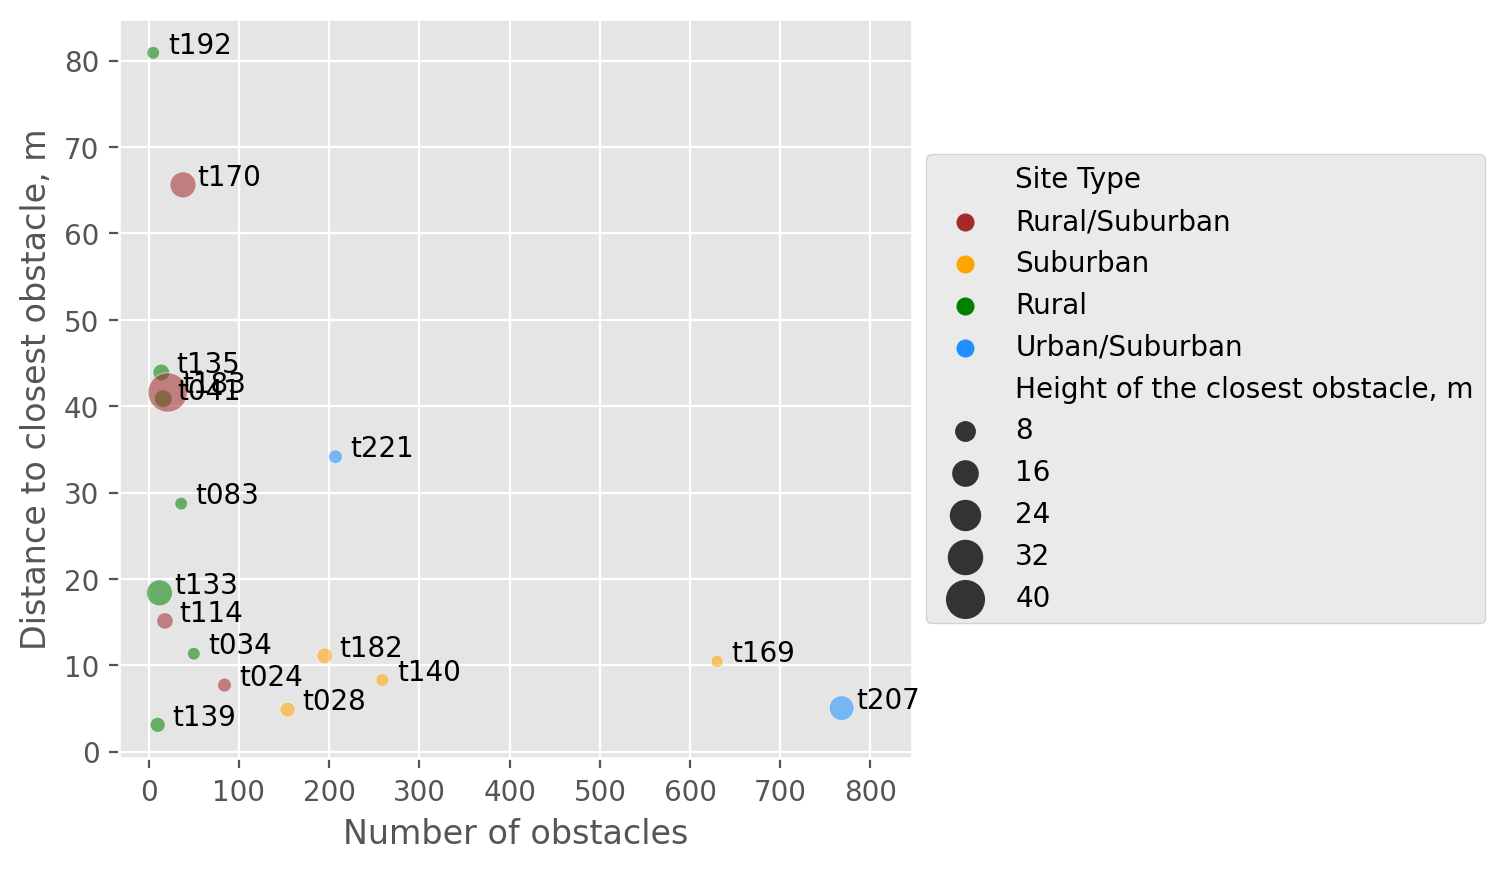

In [5]:
plt.style.use('ggplot')

sns.scatterplot(data=obstacle_specs, \
                x="Number of obstacles", \
                y="Distance to closest obstacle, m",\
                size="Height of the closest obstacle, m",
                sizes=(20, 200),
                hue="Site Type",
                alpha=0.55,
                palette=['brown', 'orange', 'green','dodgerblue']
               );

def label_points(x, y, val, ax):
    xlim = ax.get_xlim()[1]
    offset = xlim / 50  # express offest as a fraction of width
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + offset, point['y'], str(point['val']))
# Increase x axis limit to help include the label for the rightmost point
ax = plt.gca()
label_points(obstacle_specs["Number of obstacles"], \
            obstacle_specs["Distance to closest obstacle, m"], \
            obstacle_specs.tid, \
            ax)  
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1] * 1.05);

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Create a different vis with # of obstacles and their total area (all within 200m radius)

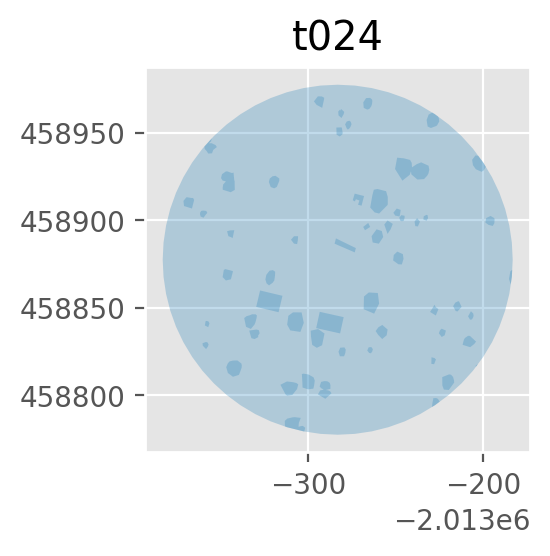

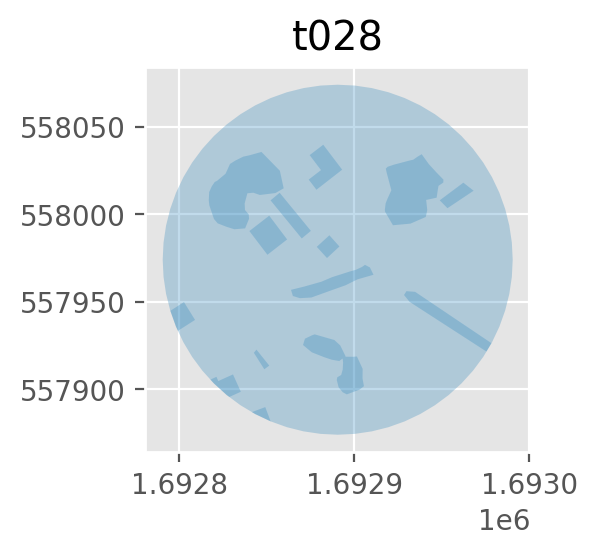

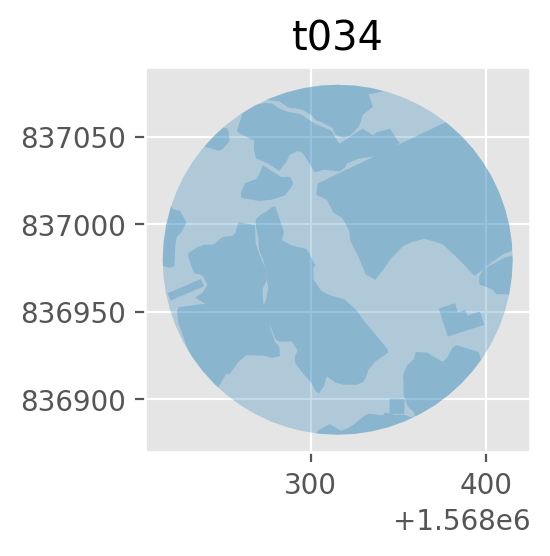

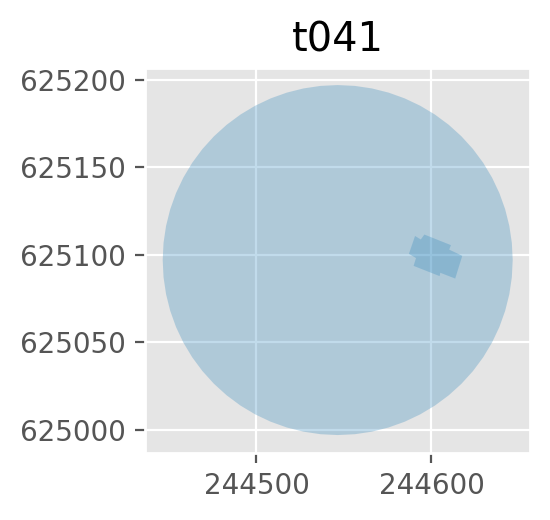

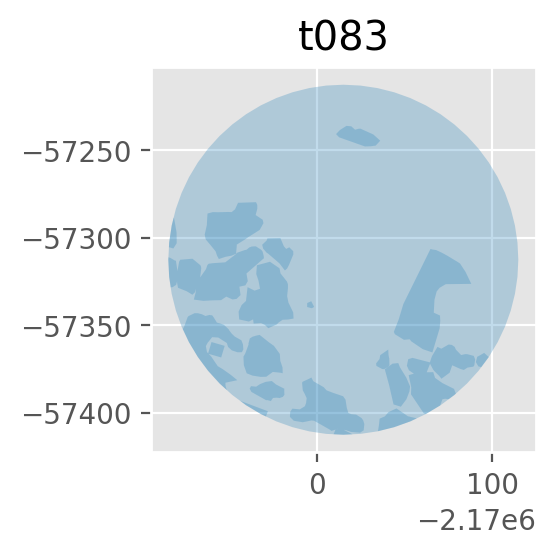

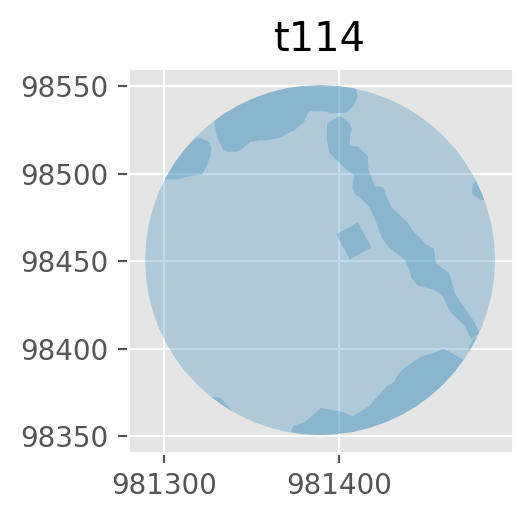

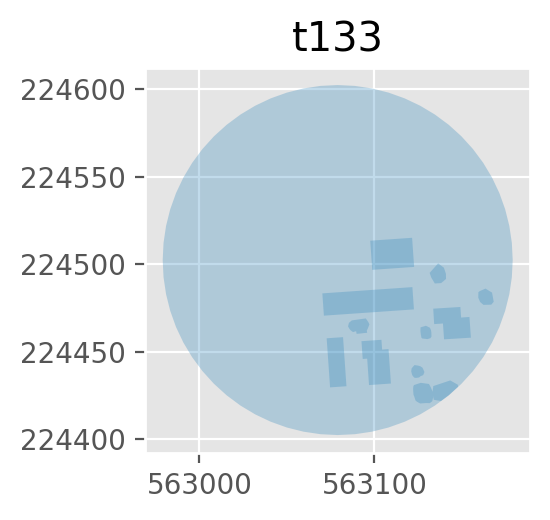

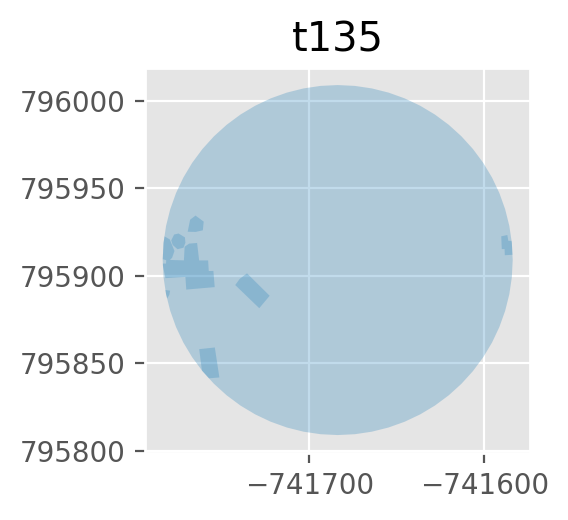

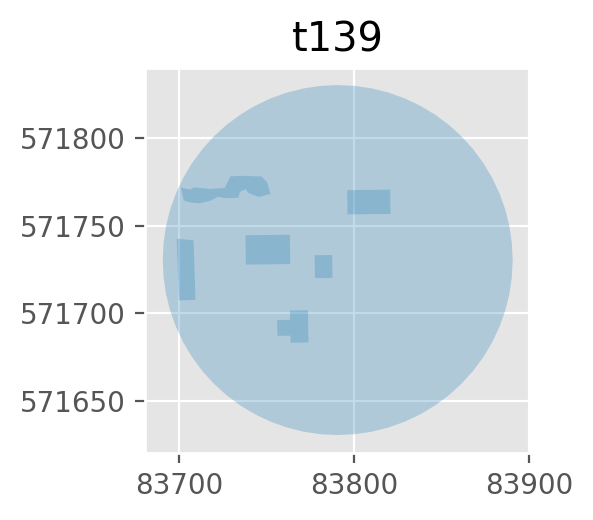

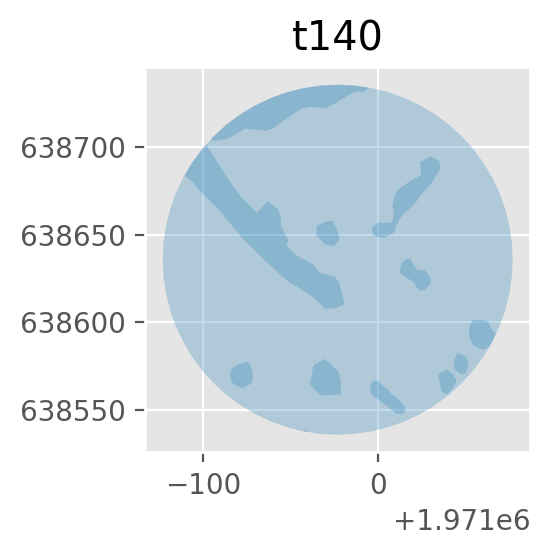

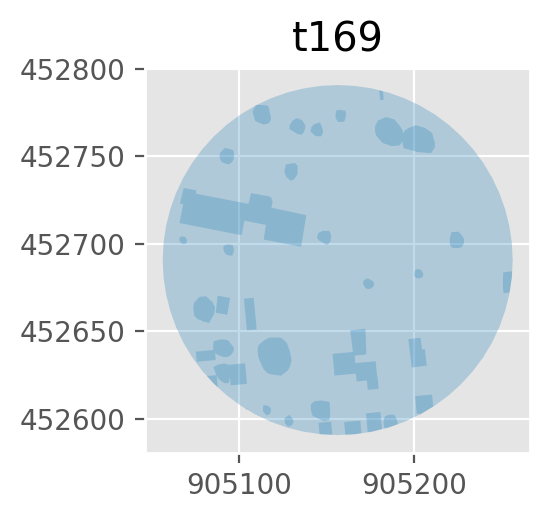

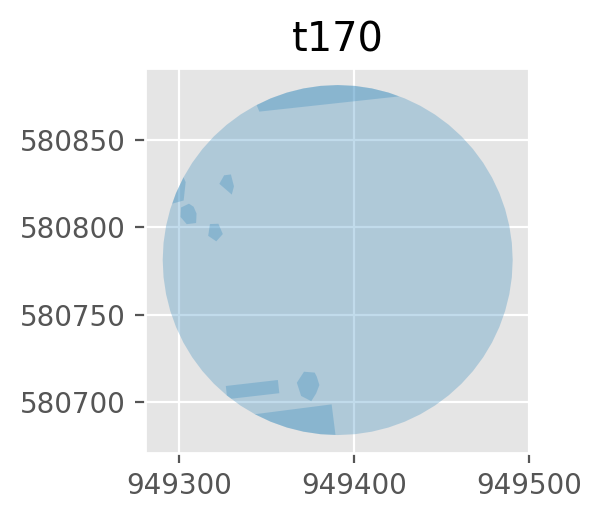

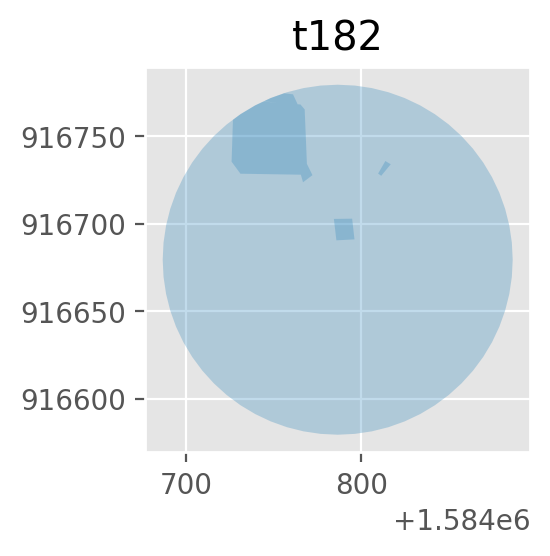

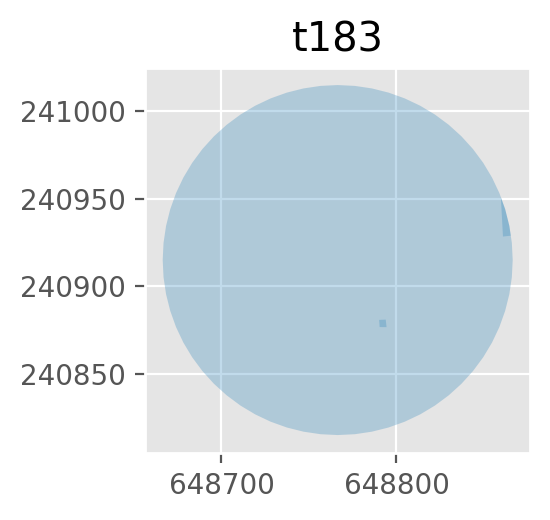

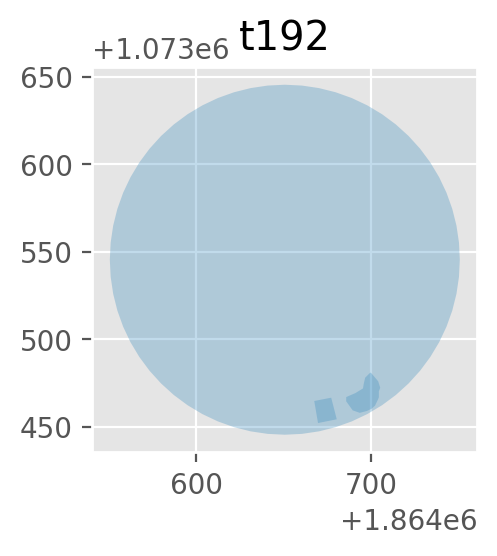

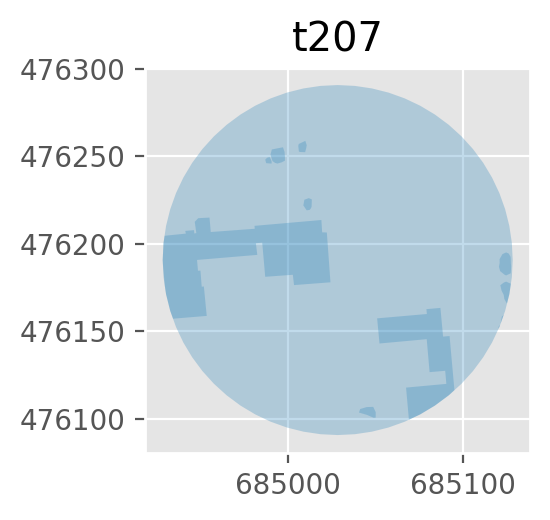

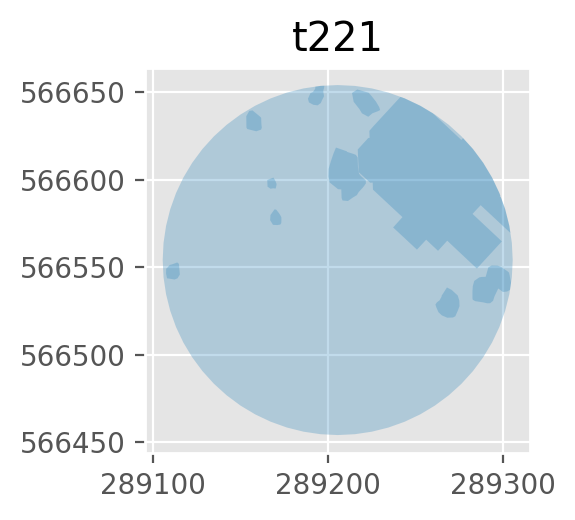

Can't access: 01 Bergey Turbine Data/3dbuildings_geojson/nanv2.json. Skipping
Can't access: 01 Bergey Turbine Data/3dbuildings_geojson/nanv2.json. Skipping
Can't access: 01 Bergey Turbine Data/3dbuildings_geojson/nanv2.json. Skipping


,tid,Number of obstacles (within 100m),Total area of obstacles (within 100m),Site Type
0,t024,56,1998.662950,Rural/Suburban
1,t028,14,4262.333070,Suburban
2,t034,11,18385.399187,Rural
3,t041,1,476.472689,Rural
4,t083,17,7019.028955,Rural
5,t114,8,5738.978928,Rural/Suburban
6,t133,11,2454.825650,Rural
7,t135,7,1004.293715,Rural
8,t139,6,1909.427758,Rural
9,t140,12,4710.478600,Suburban


In [8]:
def filter_obstacles(obstacle_df):
    selected = obstacle_df[obstacle_df["height_median"] > 1.0].copy().reset_index(drop=True)
    selected["height"] = selected["height_median"]
    return selected[["height", "geometry"]]

obstacle_specs = pd.DataFrame(columns=["tid", \
                                       "Number of obstacles (within 100m)", \
                                       "Total area of obstacles (within 100m)", \
                                       "Site Type"])
for tid in selected:
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file))
        
        row = index[index["APRS ID"] == tid].iloc[0]
        lat = row["Latitude"]
        lon = row["Longitude"]
        turbine_point = Point(_LatLon_To_XY(lat, lon))
        turbine_point_100m = turbine_point.buffer(100)
        stype = row["Site Type"]

        # This will overwrite lat/lon's with coords in meters (for distance calculation)
        for idx, row in obstacle_df.iterrows():
            obstacle_df.at[idx, "geometry"] = Polygon([Point(_LatLon_To_XY(p[1], p[0])) for p in row["geometry"].exterior.coords])
        #display(obstacle_df)
        
        u = unary_union([p.intersection(turbine_point_100m) for p in obstacle_df.geometry])
        boundary = gpd.GeoSeries(u)
        boundary[1] = turbine_point_100m
        boundary.plot(alpha=0.3, figsize=(2.5, 2.5)).set_title(tid)
        plt.show()
        
        if type(u) == MultiPolygon:
            obstacle_count = len(u.geoms)
        else:
            # assume single polygon
            obstacle_count = 1
        obstacle_specs.loc[len(obstacle_specs)] = [tid, obstacle_count, u.area, stype]
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

display(obstacle_specs)

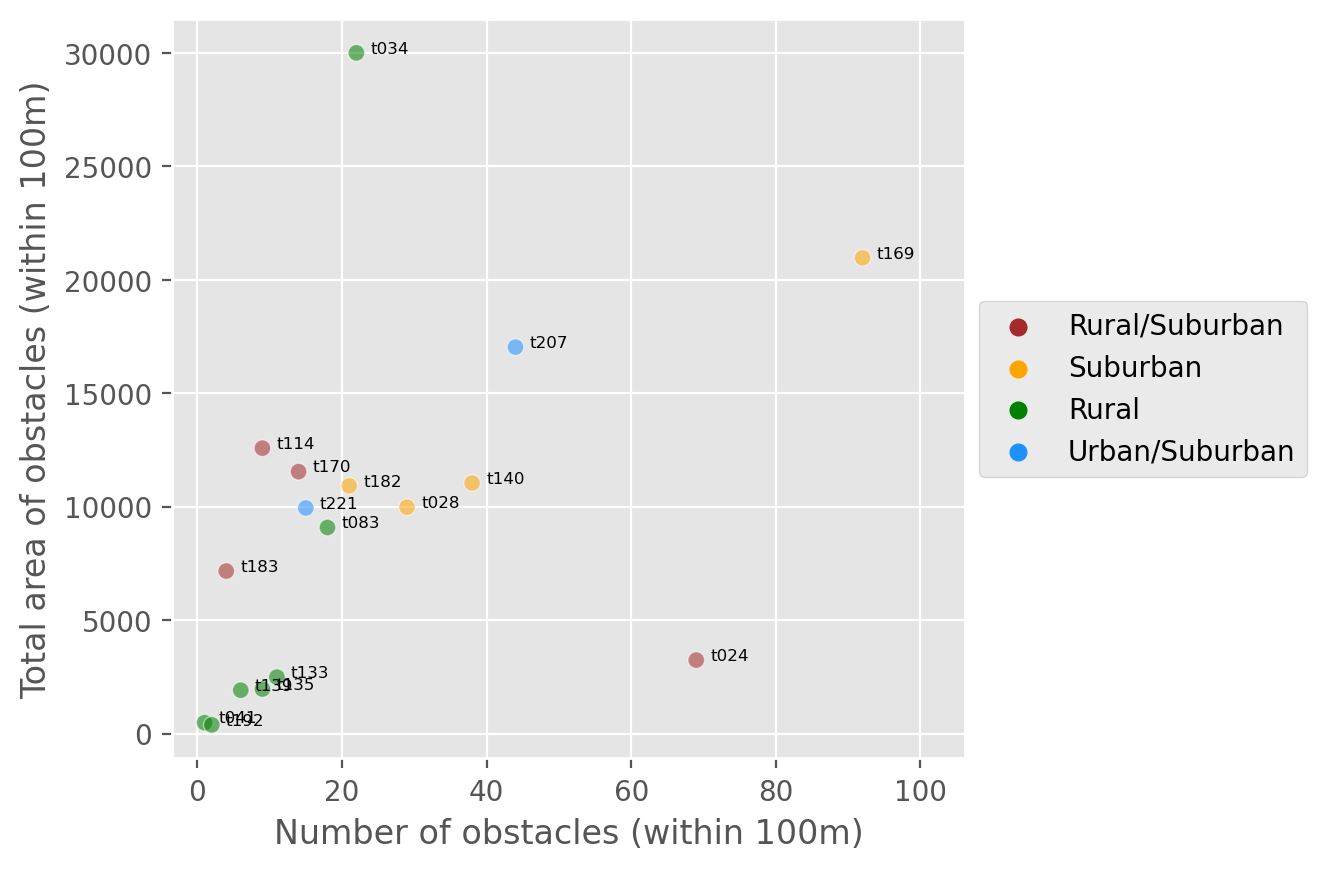

In [7]:
plt.style.use('ggplot')

sns.scatterplot(data=obstacle_specs, \
                x="Number of obstacles (within 100m)", \
                y="Total area of obstacles (within 100m)",\
                hue="Site Type",
                alpha=0.55,
                palette=['brown', 'orange', 'green','dodgerblue']
               );

def label_points(x, y, val, ax):
    xlim = ax.get_xlim()[1]
    offset = xlim / 50  # express offest as a fraction of width
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + offset, point['y'], str(point['val']), fontsize=6.0)
# Increase x axis limit to help include the label for the rightmost point
ax = plt.gca()
label_points(obstacle_specs["Number of obstacles (within 100m)"], \
            obstacle_specs["Total area of obstacles (within 100m)"], \
            obstacle_specs.tid, \
            ax)  
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1] * 1.10);

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()